#Predict geographical origin of music

##Get the data
The dataset can be obtained at http://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music   
Unzip it to PATH_TO_DS_HK_5/ds/data/final_project  
We will be using the file called "default_features_1059_tracks.txt"  

## About the data
The dataset contains attributes of 1059 tracks of ethnic or traditional music.

The 1st 68 attributes (columns) are "audio features" extracted from each song using MARSYAS software.
The remaining 2 columns correspond to the latitude and longitude of the artist(s)' main country/ area of residence.

More info can be found at: http://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music

##Audio features extraction with MARSYAS

These audio features have been extracted from each songtrack using MARSYAS.  

MARSYAS(Music Analysis, Retrieval and Synthesis for Audio Signals) is an open source software framework for audio processing with specific emphasis on Music Information Retrieval applications.

###Installation of MARSYAS

On Linux, MARSYAS needs to be built from source. Get the source from https://github.com/marsyas/marsyas/archive/release/0.5.zip and follow the build instructions at http://marsyas.info/doc/manual/marsyas-user/Building-latest-Marsyas-on-Debian_002fUbuntu.html#Building-latest-Marsyas-on-Debian_002fUbuntu 

Note: if you get an error related to "Qt" while running "cmake" from within your vagrant VM. Re-run using the following option: 
`cmake .. -DWITH_QT=OFF`


###Audio features
####General definitions

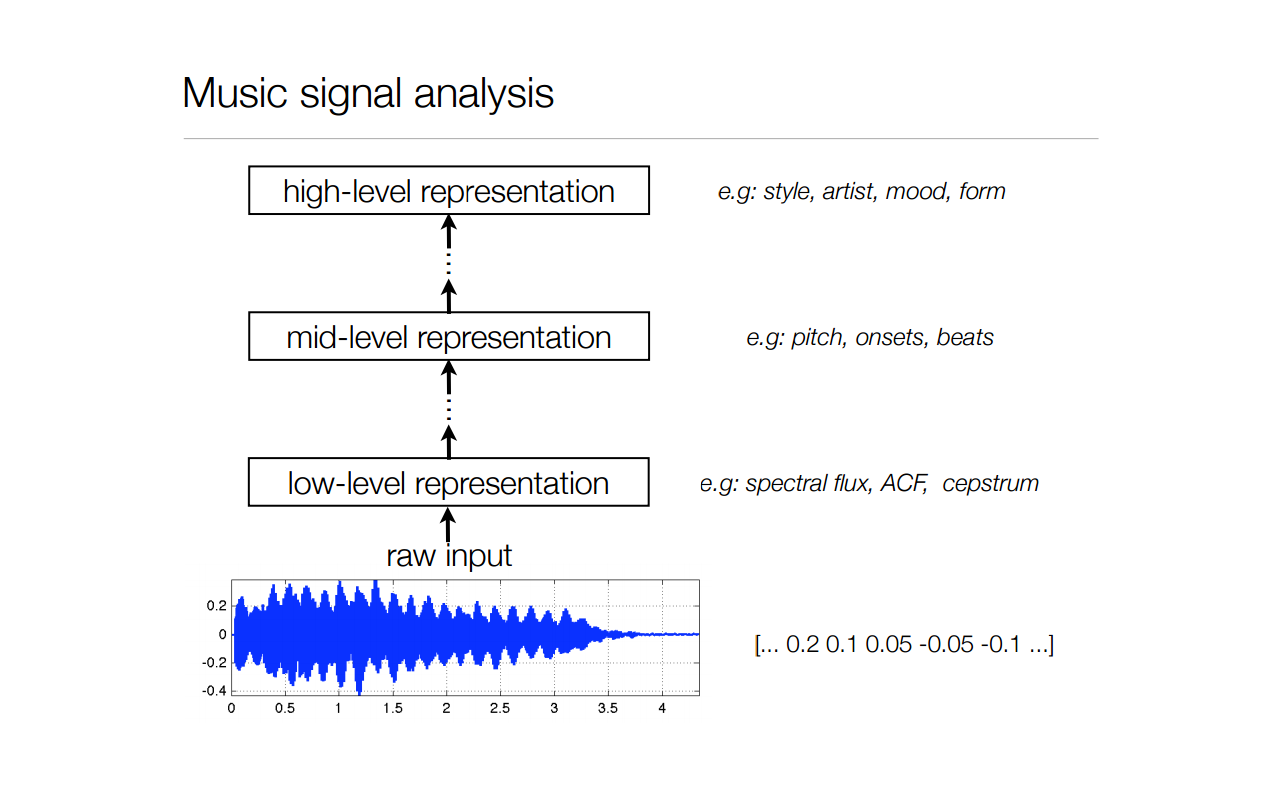

In [5]:
from IPython.display import Image
Image(filename='music_analysis.png',width=600,height=500) 



 - Features: measurable properties of the input signal.  
 
 - Feature extraction: the input raw signal is transformed into a smaller set of variables to simplify analysis.  
 
 - Timbre: tonal qualities that define a particular sound/source. It can refer to, e.g., class (e.g. violin or piano), or quality (e.g. bright, rough).  Timbre is an attribute that allows us to differentiate sounds of the same pitch, loudness, duration and spatial location.
 

####About audio features of our dataset
"The information or features extracted from each tracks of the dataset are timbral features. Each of these is an indicator of timbre, which is one of the main ways to distinguish instruments. Since instrumentation is also a major difference between cultural music traditions, these are appropriate to the task. No feature weighting or pre-ﬁltering was applied."

All features values have been normalized: std=1 and mean=0

The authors don't give details about the settings used on MARSYAS to extract these 68 features - other than using "default" MARSYAS settings. However after playing around with MARSYAS, I have been able to extract a set of 68 features that matches audio metrics listed in the paper written by the authors (see Annex paragaphs).

The extracted 68 audio features are of the following types:

####Time Zero Crossings
Features #: 0, 17, 34, 51  
Zero-crossing rate (ZCR) is a weighted measure of the number of times the signal changes sign in a frame. It is high for noisy (unvoiced) sounds and low for tonal (voiced) sounds.

####Spectral Centroid
Features #: 1, 18, 35, 52  
The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the "center of mass" of the spectrum is. Perceptually, it is usually associated with the sound’s “brightness”.  

####Spectral Flux
Features #: 3, 20, 37, 54  
Spectral flux is a measure of how quickly the power spectrum of a signal is changing.

####Spectral Rolloff
Features #: 2, 19,36, 53  
The spectral rolloff point is the fraction of bins in the power spectrum at which 85% of the power is at lower frequencies.
It is another measure of spectral shape.

####Mel-Frequency Cepstral Coefficients (MFCC)
Features #: 4-16, 21-33, 38-50, 55-67  
Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition due to their ability to compactly represent the audio spectrum.  




To have more details on the exact 68 features extracted by MARSYAS, please refer to Annex A.

##Preliminaries

In [63]:
import sys
import sklearn
print pd.__name__, pd.__version__
print np.__name__, np.__version__
print mpl.__name__, mpl.__version__
print sns.__name__, sns.__version__
print sklearn.__name__, sklearn.__version__
print sys.version

pandas 0.16.0
numpy 1.9.2
matplotlib 1.4.3
seaborn 0.5.1
sklearn 0.16.1
2.7.6 (default, Mar 22 2014, 22:59:56) 
[GCC 4.8.2]


In [2]:
%matplotlib inline
#TODO: clean imports
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import matplotlib as mpl


from pylab import *

from IPython.display import HTML
from IPython.display import display as prnt

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn import metrics
from sklearn import preprocessing

pd.set_option('display.precision',4)
pd.set_option('display.float_format', lambda x: '%.2f' %x)



# Notebook Options
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})

### Utility function

In [3]:
def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

## 1st look at the data set

In [4]:
#let's load the data set
df = pd.read_csv('../data/final_project/default_features_1059_tracks.txt', header=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Data columns (total 70 columns):
0     1059 non-null float64
1     1059 non-null float64
2     1059 non-null float64
3     1059 non-null float64
4     1059 non-null float64
5     1059 non-null float64
6     1059 non-null float64
7     1059 non-null float64
8     1059 non-null float64
9     1059 non-null float64
10    1059 non-null float64
11    1059 non-null float64
12    1059 non-null float64
13    1059 non-null float64
14    1059 non-null float64
15    1059 non-null float64
16    1059 non-null float64
17    1059 non-null float64
18    1059 non-null float64
19    1059 non-null float64
20    1059 non-null float64
21    1059 non-null float64
22    1059 non-null float64
23    1059 non-null float64
24    1059 non-null float64
25    1059 non-null float64
26    1059 non-null float64
27    1059 non-null float64
28    1059 non-null float64
29    1059 non-null float64
30    1059 non-null float64
31    1059 non-null float

Data types are ok, no missing data

In [4]:
table(df.head())

In [5]:
#rename columns
#int from 0 to 67 for audio features
labels = range(0,68)
# lat and lon for last 2 columns
labels.extend(['lat','lon'])

df.columns= labels 


In [6]:
#random sample of rows
from random import sample

df.ix[sample(df.index,10)]

0     1     2     3     4     5     6     7     8     9  ...      60  \
312 -0.08 -0.28 -0.66 -0.89 -0.15  0.10 -0.68 -0.66 -0.79 -1.17  ...   -0.38   
615  1.36  1.61 -0.08 -0.83 -0.67 -2.10 -3.15 -2.19 -1.79 -1.65  ...   -0.26   
694  0.31  0.19 -0.46  0.09 -0.07  0.09 -0.61  0.42 -0.34  0.21  ...    0.15   
221 -0.05 -0.41 -0.18 -0.33 -0.31 -0.74  0.52  0.25  0.98  0.23  ...   -0.88   
170  0.07  0.25  1.14  0.62  0.97 -1.27  0.57 -0.23  0.41  0.18  ...   -0.53   
271 -0.53 -0.66 -0.53 -0.35  0.15  0.90  0.65 -0.20 -0.66  1.61  ...    0.69   
813  0.52  0.12  0.00  2.21 -0.67 -0.67  0.54  0.22  0.98  0.82  ...    0.21   
920  6.08  5.27  4.45  0.01 -0.39  1.70 -0.50  0.46  0.74 -0.04  ...   -0.13   
897 -0.59 -0.67 -0.43  0.80  0.83  0.12 -0.13  3.13 -1.21  0.79  ...   -0.03   
841 -0.56 -0.75 -0.20 -0.04 -0.61  0.67  0.74  1.11  1.38  0.34  ...    0.66   

       61    62    63    64    65    66    67   lat    lon  
312  1.08  0.07  0.58  1.23  0.02 -0.42  0.65 23.76 121.00  
615  2.00  1.05  1.63  1.09  1.49  1.67  1.93 39.91 116.38  
694  1.15  0.14 -0.53  0.09 -0.08 -0.22  0.19 36.70   3.21  
221 -0.93 -1.47 -0.78  0.01 -0.56 -0.62 -0.61 28.61  77.20  
170 -0.88 -0.26 -0.80 -0.87 -0.85 -0.69 -0.73 36.70   3.21  
271  1.08  0.02  0.65  0.64  0.67  1.43  1.30 52.50  -0.12  
813  0.02  0.22 -0.22 -0.69 -0.12 -0.41  0.07 39.91  32.83  
920 -1.31 -1.22 -0.54 -0.71 -0.55 -0.75 -0.23 41.90  12.48  
897  0.45 -0.08 -0.72 -0.15  0.71 -0.33 -0.35  9.03  38.74  
841  1.01  2.43 -0.13  0.13 -0.29  0.18 -0.69 12.65  -8.00  

[10 rows x 70 columns]

##EDA

###Univariate

In [7]:
table(df.describe())

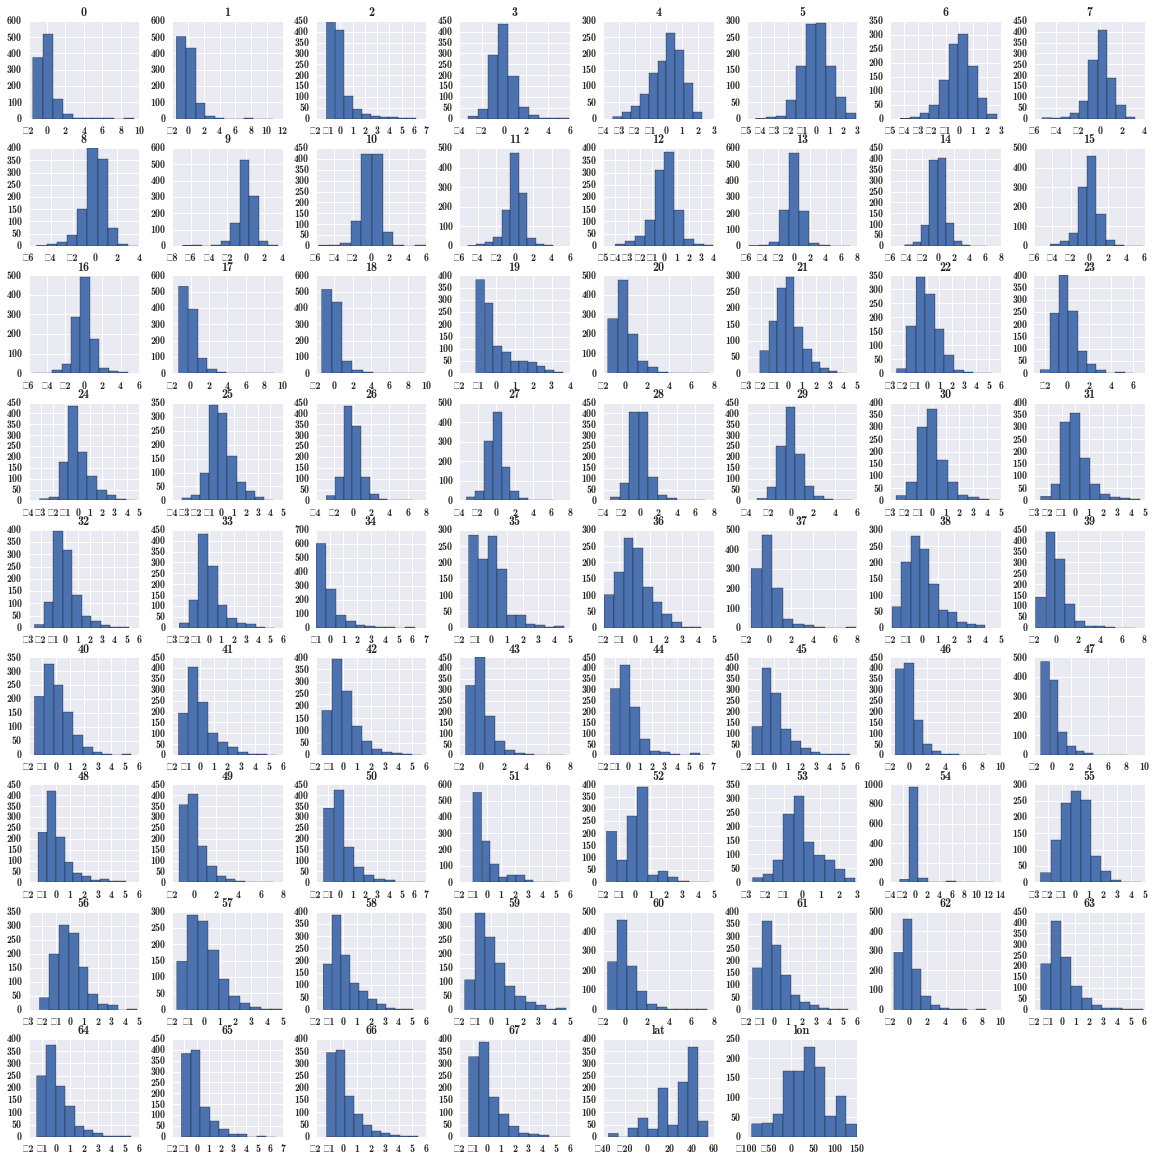

In [6]:
import seaborn as sns


df.hist( figsize=(20, 20));

We can notice outliers on features: 0,1,9,34,37,40,44,54,56 and 62.

###Multivariate

A quick look at relationships of 1st features using lat and lon as hue

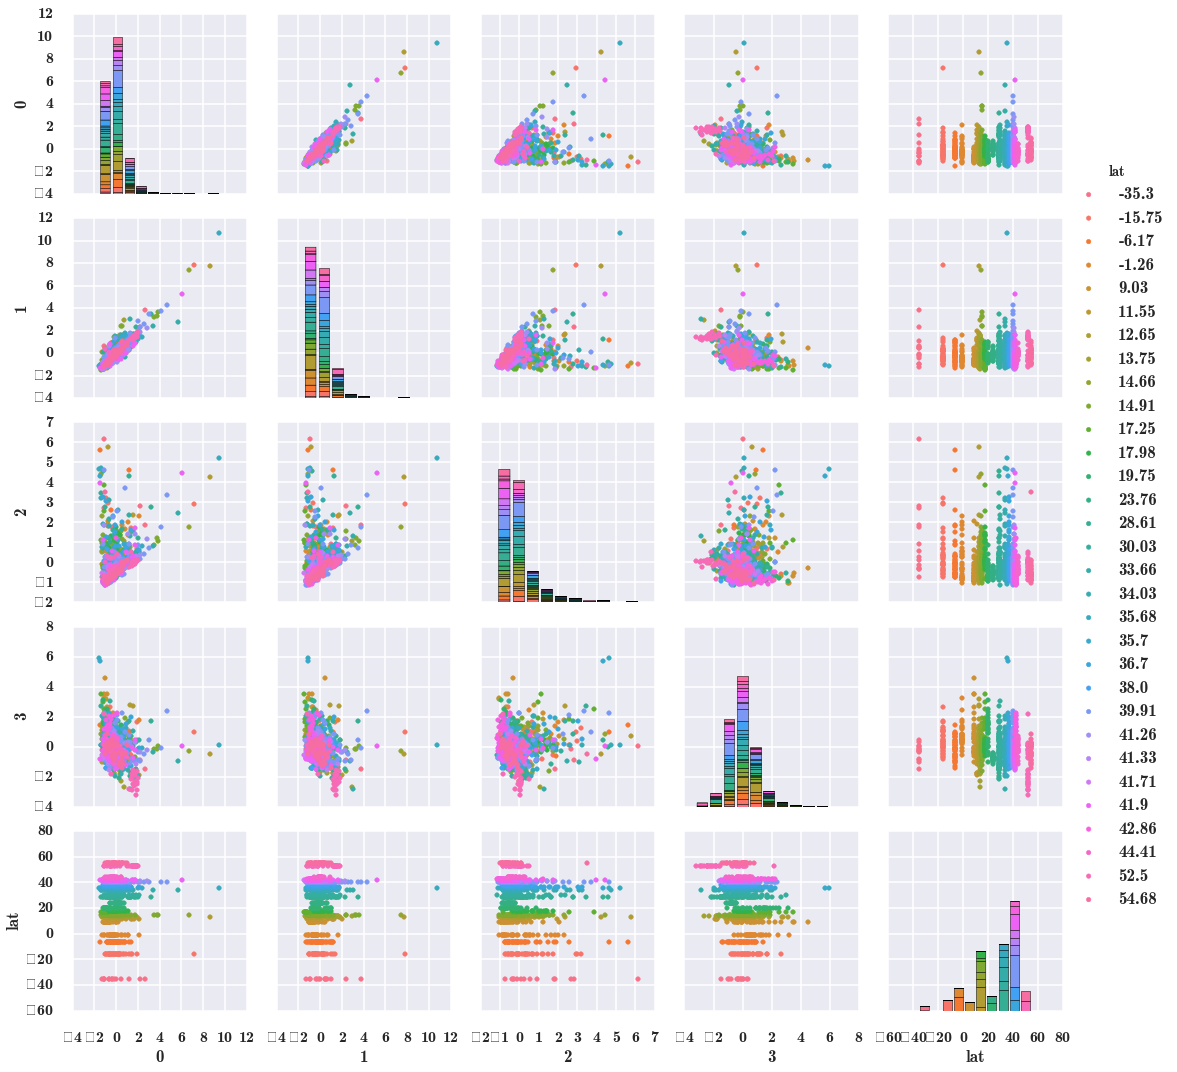

In [23]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.PairGrid(df[[0,1,2,3,'lat']], hue="lat")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()

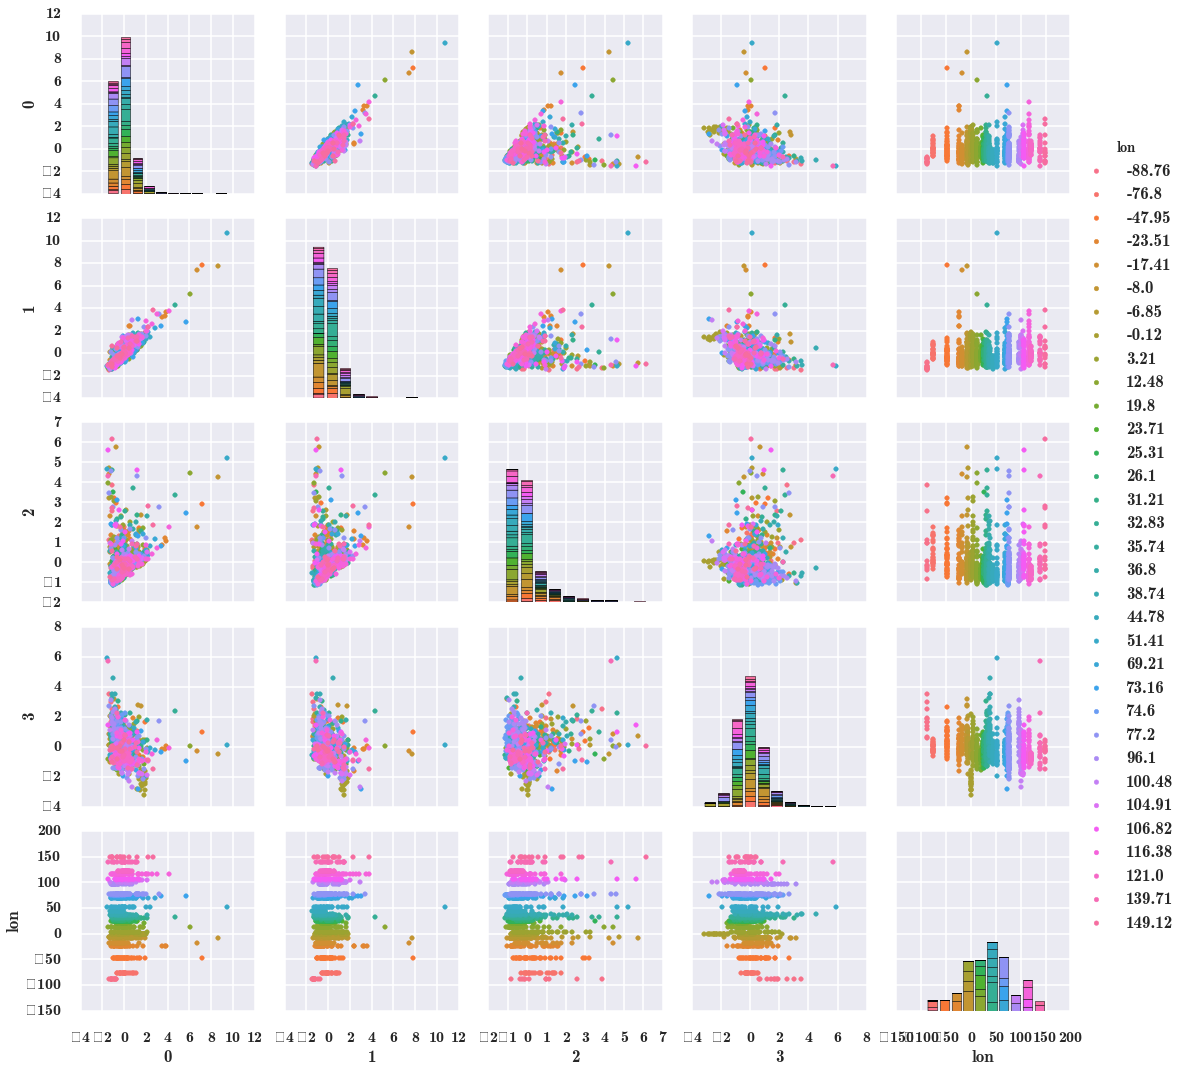

In [24]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.PairGrid(df[[0,1,2,3,'lon']], hue="lon")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()

We can notice that outliers on scatter plots are not from extrem latitudes or longitudes.  
By the shapes of some scatter plots we can already see that some features are correlated (linearly or not).

####Correlation plot

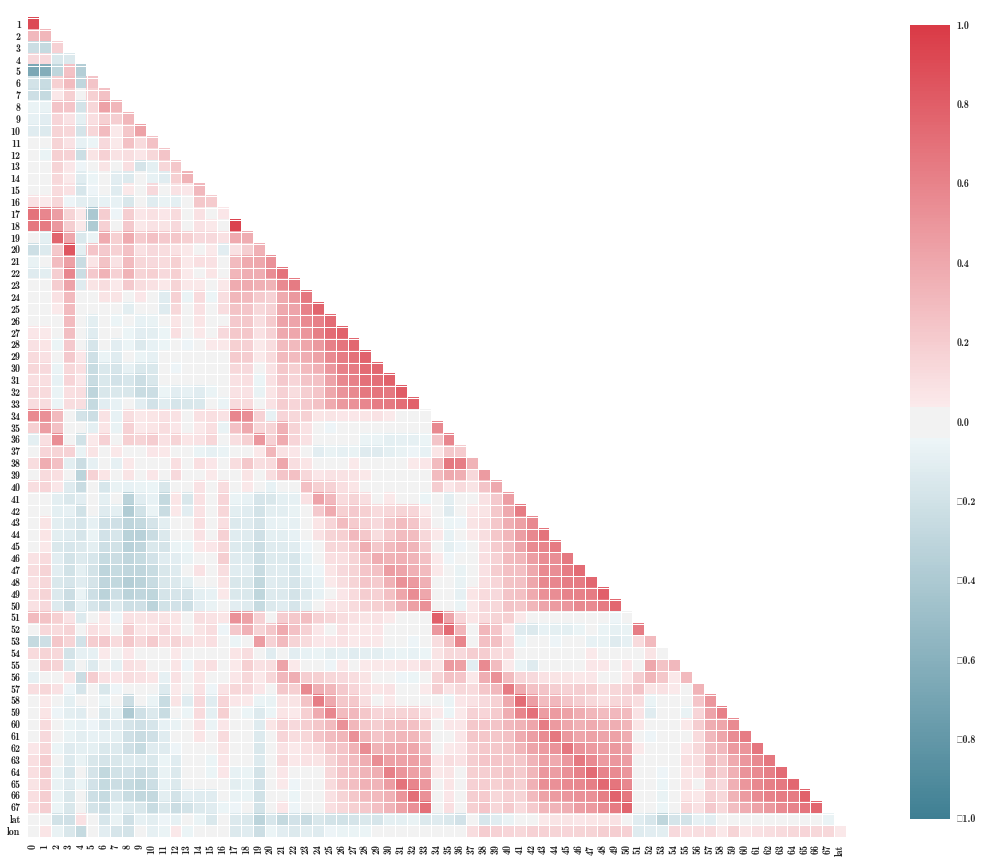

In [22]:
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(df, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

We can notice that the 1st 13 audio features are not correlated with each other but that some others seem strongly correlated between each other: one explanation could be that they are calculated using same raw signal data or signal processing techniques 

###Latitudes and longitudes

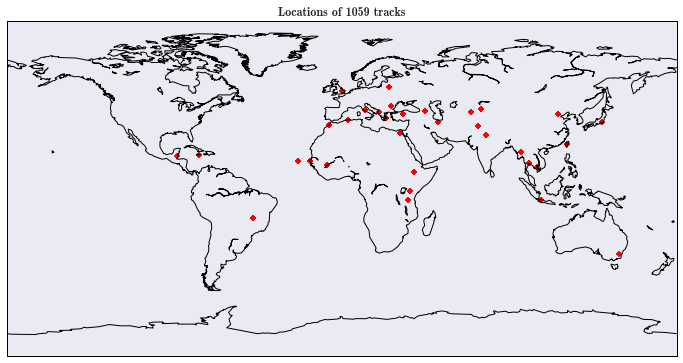

In [26]:
#let's try to plot our latitudes and longitudes on a map to visualize where the tracks are coming from
import numpy as np
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
from datetime import datetime



lons = [ i for i in df.iloc[:,-1]]
lats = [ j for j in df.iloc[:,-2]]
plt.figure(figsize=(12,6))
map = Basemap(lat_0=0, lon_0=0)



# plot coastlines.
map.drawcoastlines()
map.drawmapboundary()


x, y = map(lons, lats)

map.scatter(x,y,10,marker='D',color='r')


plt.title('Locations of 1059 tracks',fontsize=12)
plt.show()

The country of origin was determined by the artist's or artists' main country/area of residence. Any track that had ambiguous origin was not included. The authors of the dataset have taken the position of each country's capital city (or the province of the area) by latitude and longitude as the absolute point of origin. 

In [27]:
#trying to find how many unique (longitude;latitude) they are, i.e. how many different regions of the world 
#are represented in this dataset


Ys = df.iloc[:,68:].copy(deep=True)
print Ys.head()
# 33 different regions
Ys = Ys.drop_duplicates() 
Ys.index = range(Ys['lat'].count())
Ys.count()

     lat    lon
0 -15.75 -47.95
1  14.91 -23.51
2  12.65  -8.00
3   9.03  38.74
4  34.03  -6.85


lat    33
lon    33
dtype: int64

In [5]:
#let's install geopy to map those coordinates to locations
!pip install geopy

The directory '/home/vagrant/.cache/pip/log' or its parent directory is not owned by the current user and the debug log has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/vagrant/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/vagrant/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL

In [28]:
#let's map those coordinates to countries or regions

from geopy.geocoders import Nominatim

def find_addr_from_coord(str_coords):

    geolocator = Nominatim()
    location= geolocator.reverse(str_coords,timeout=10,language="en")
    return location


Ys['address'] =Ys.apply(lambda row: find_addr_from_coord(str(row['lat'])+","+str(row['lon'])) ,axis=1)



In [52]:
print table(Ys)

None


In [117]:
#parse and format the locations, so that they are more legible
def parse_addr(row):
    f_addr=""
    if 'city' in row['address'].raw['address']:
        f_addr= row['address'].raw['address']['city']#.encode('utf-8') 

        
    elif 'town' in row['address'].raw['address']:
        f_addr= row['address'].raw['address']['town']#.encode('utf-8') 

       
    elif 'village' in row['address'].raw['address']:
        f_addr= row['address'].raw['address']['village']#.encode('utf-8') 

        
    elif 'neighbourhood' in row['address'].raw['address']:
        f_addr= row['address'].raw['address']['neighbourhood']#.encode('utf-8') 

    
    elif 'suburb' in row['address'].raw['address']:
        f_addr= row['address'].raw['address']['suburb']#.encode('utf-8') 

    
#    print (f_addr + " ("+ row['address'].raw['address']['country']+")").encode('utf-8')
#    return f_addr +" ("+ row['address'].raw['address']['country'].encode('utf-8') + ")"
    return (f_addr + " ("+ row['address'].raw['address']['country']+")").encode('utf-8')

Ys['formatted_address'] =Ys.apply(lambda row:parse_addr(row) ,axis=1)


In [120]:
print Ys['formatted_address']
#turn each unique address/location into an int
Ys['num_addr'] = range(0,33)


0                        Brasília (Brazil)
1                       Praia (Cape Verde)
2                            Bamako (Mali)
3                   Addis Abeba (Ethiopia)
4                          Rabat (Morocco)
5                          Dakar (Senegal)
6                 Fenland (United Kingdom)
7                    Tashkent (Uzbekistan)
8                             Rome (Italy)
9                        New Delhi (India)
10                 Chak Shehzad (Pakistan)
11                     Vilnius (Lithuania)
12                     Bucharest (Romania)
13                  Dar El Beida (Algeria)
14                         Ankara (Turkey)
15                     Naypyidaw (Myanmar)
16                     Siri Rat (Thailand)
17    Beijing (People's Republic of China)
18          Sinyi Town (Republic of China)
19                       RW 08 (Indonesia)
20                      Kingston (Jamaica)
21                           Tehran (Iran)
22                            Giza (Egypt)
23         

In [121]:

# map those regions/locations to each of the 1059 rows of the original dataset
result = pd.merge(df, Ys,how='left', on=['lat', 'lon'])



In [ ]:
#backup dataset to CSV file
result.to_csv("../data/final_project/final_project_with_formatted_addr.csv", encoding='utf-8')

In [123]:
#restore backed up data set
result = pd.read_csv("../data/final_project/final_project_with_formatted_addr.csv",index_col=0)
from random import sample
table( result.ix[sample(result.index,10)])

Let's check the distribution of our songtracks:

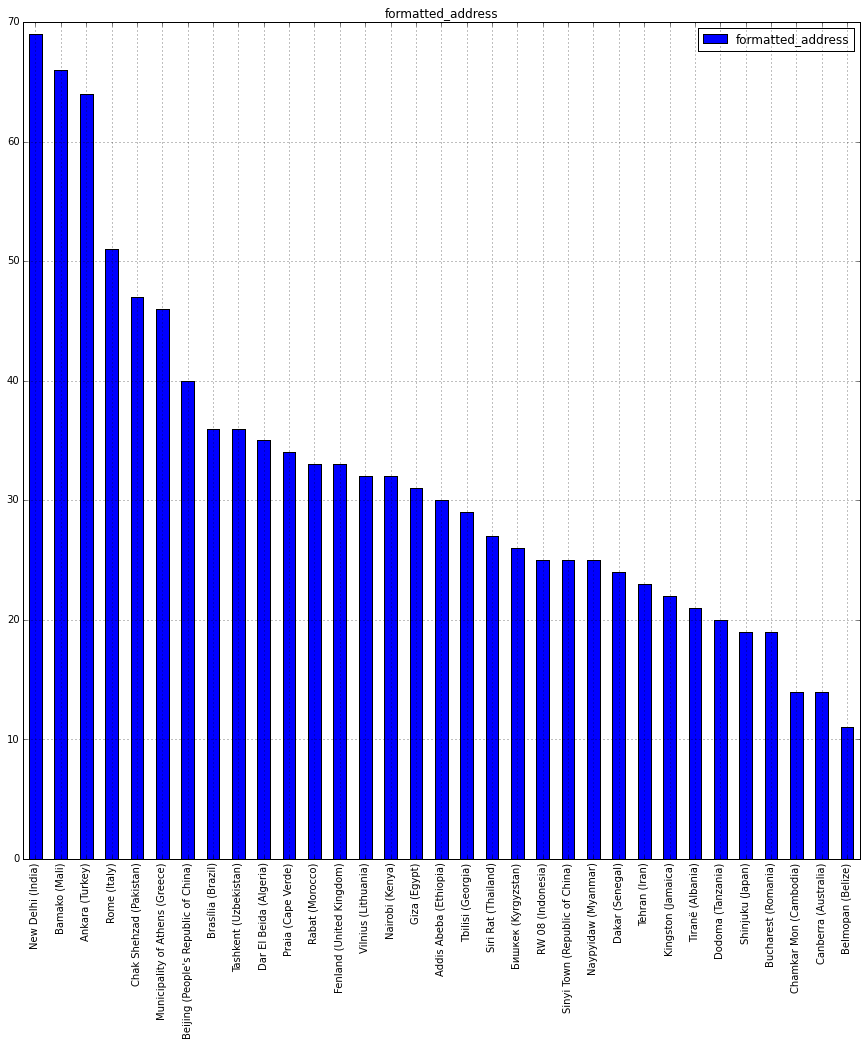

In [5]:
df2 = pd.DataFrame(result['formatted_address']) 
df2.apply(pd.value_counts).plot(kind='bar', subplots=True,figsize=(15,15));

Authors of the data set were probably fans of Indian, Malian and Turkish music!

##Classification on original dataset

Before doing any feature engineering let's try several classification techniques on our initial dataset:

In [4]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# use 0 to 67 columns
X1 = result.iloc[:,:68]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.222809026149
RandomForestClassifier: [ 0.32142857  0.39660057  0.33333333]
ExtraTreesClassifier:   [ 0.33241758  0.41076487  0.35087719]


Classification on original dataset (before PCA or LDA) does not give very good scores. Let's try different approaches to see if we can get a higher score.

###Bagging

In [42]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


# use resulting dataset from LDA as Xs
X1 = result.iloc[:,:68]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

## DecisionTreeClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0),bootstrap=True,bootstrap_features=False)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()



DecisionTreeClassifier: 0.310663434937


###Boosting

In [43]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


# use resulting dataset from LDA as Xs
X1 = result.iloc[:,:68]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


## DecisionTreeClassifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0))
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()


DecisionTreeClassifier: 0.222960885179


###PCA


Note that the dataset has already been normalized.

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
Xs = result.iloc[:,:68]
pca.fit(Xs)



PCA(copy=True, n_components=None, whiten=False)

In [6]:
table(Xs.head())

####Plot variance associated with PCs

[u'pc0', u'pc1', u'pc2', u'pc3', u'pc4', u'pc5', u'pc6', u'pc7', u'pc8', u'pc9', u'pc10', u'pc11', u'pc12', u'pc13', u'pc14', u'pc15', u'pc16', u'pc17', u'pc18', u'pc19', u'pc20', u'pc21', u'pc22', u'pc23', u'pc24', u'pc25', u'pc26', u'pc27', u'pc28', u'pc29', u'pc30', u'pc31', u'pc32', u'pc33', u'pc34', u'pc35', u'pc36', u'pc37', u'pc38', u'pc39', u'pc40', u'pc41', u'pc42', u'pc43', u'pc44', u'pc45', u'pc46', u'pc47', u'pc48', u'pc49', u'pc50', u'pc51', u'pc52', u'pc53', u'pc54', u'pc55', u'pc56', u'pc57', u'pc58', u'pc59', u'pc60', u'pc61', u'pc62', u'pc63', u'pc64', u'pc65', u'pc66', u'pc67']


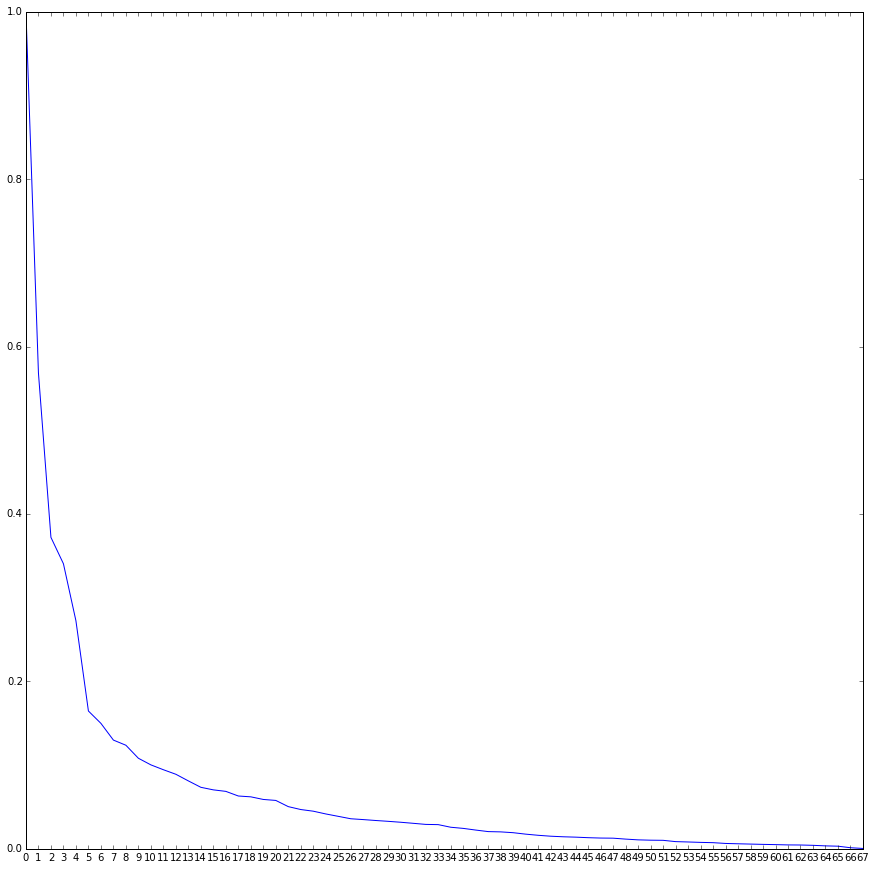

In [7]:
labels=['pc' + str(pc) for pc in range (0,68)]
var = pca.explained_variance_ratio_ / max(pca.explained_variance_ratio_)
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0, 70, 1))
plt.plot(var)

print labels

This plot returns a plot of the variances associated with the PCs. We can see that the first 5 PCs (from pc0 to pc4) are enough to explain most of the variance in the data set

In [8]:
df_pca = pd.DataFrame(pca.transform(Xs),columns=labels)
table(df_pca.head())

Now let's run a classification algorithm on our freshly built PCA dataset, using only the five 1st PCs.  
###Classification: random forests

In [124]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# use resulting the 1st 5 PCs of our PCA dataset 
X1 = df_pca.iloc[:,:5]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.180615320656
RandomForestClassifier: [ 0.21703297  0.24645892  0.19005848]
ExtraTreesClassifier:   [ 0.20604396  0.22946176  0.21052632]


Scores using our five first PCs is even worse than by doing classification directly on original dataset.   

Fortunately a 2nd dataset is provided by the authors: it contains the same 68 audio features plus 48 chromatic features.

"These  [chromatic features] describe the notes of the scale being used. This is especially important as a distinguishing feature in geographical ethnomusicology. The chromatic features provided by MARSYAS are 12 per octave - Western tuning, but it may be possible to tell something from how similar to or different from Western tuning the music is."

Let's use this 2nd dataset and see if we can get better results.

##Using the 2nd dataset with chromatic features


Columns 0 to 115 are audio features and the last two are latitude and longitude.  



In [124]:
df3 = pd.read_csv("/home/vagrant/ds/DS_HK_5/data/final_project/default_plus_chromatic_features_1059_tracks.txt",header=None)
df3.info()
df3.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Columns: 118 entries, 0 to 117
dtypes: float64(118)
memory usage: 984.5 KB


0     1     2    3     4     5     6     7     8     9    ...     108  \
0  7.16  7.84  2.91 0.98 -1.50 -2.09  0.58 -1.21  1.85 -0.43  ...   -0.36   
1  0.23 -0.09 -0.60 0.50  0.87  0.29 -0.08 -0.89  0.43 -0.09  ...    0.94   
2 -0.69 -0.52 -0.79 1.21 -0.91  0.88  0.41 -0.69 -0.90 -1.70  ...    0.60   
3 -0.74 -0.68  2.06 0.72 -0.01  0.81  1.50  0.11  0.69  0.05  ...    0.19   
4  0.57  0.27 -0.28 0.08  1.05 -0.87 -0.27 -0.40 -0.87  1.15  ...    1.62   

    109   110   111   112   113   114   115    116    117  
0 -0.36 -0.36 -0.36 -0.36 -0.36 -0.36 -0.36 -15.75 -47.95  
1  0.94  0.94  0.94  0.94  0.94  0.94  0.94  14.91 -23.51  
2  0.60  0.60  0.60  0.60  0.60  0.60  0.60  12.65  -8.00  
3  0.19  0.19  0.19  0.19  0.19  0.19  0.19   9.03  38.74  
4  1.62  1.62  1.62  1.62  1.62  1.62  1.62  34.03  -6.85  

[5 rows x 118 columns]

In [69]:
from random import sample

table(df3.ix[sample(df3.index,10)])

Since no details are provided by the authors about which column correspond to which audio feature we can only guess by comparing the 2 datasets.

Chromatic features seem to be redundant, since we notice ranges of them with the same value:  
- \# 17-28 (12 features)  
- \# 46-57 (12 features)
- \# 75-86 (12 features)
- \# 104-115 (12 features)

which gives us a total of 48 chromatic features. 


###Classification on 2nd dataset

In [27]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

#use first 116 columns (0 to 115)
X1 = df3.iloc[:,:116]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.21315722419
RandomForestClassifier: [ 0.32142857  0.37393768  0.32748538]
ExtraTreesClassifier:   [ 0.28296703  0.34560907  0.28654971]


Scores are not that better, let's try feature selection and feature engineering.

## Feature Selection (using 2nd dataset)

###Redundant features

In [28]:
# use 2nd dataset
X1 = df3.iloc[:,:116]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

cor = X1.corr()
cor.loc[:,:] = np.tril(cor.values,k=-1)
cor=cor.stack()
print cor[cor>0.8]

1    0     0.91
18   17    1.00
19   17    1.00
     18    1.00
20   17    1.00
     18    1.00
     19    1.00
21   17    1.00
     18    1.00
     19    1.00
     20    1.00
22   17    1.00
     18    1.00
     19    1.00
     20    1.00
     21    1.00
23   17    1.00
     18    1.00
     19    1.00
     20    1.00
     21    1.00
     22    1.00
24   17    1.00
     18    1.00
     19    1.00
     20    1.00
     21    1.00
     22    1.00
     23    1.00
25   17    1.00
           ... 
115  51    0.84
     52    0.84
     53    0.84
     54    0.84
     55    0.84
     56    0.84
     57    0.84
     75    0.89
     76    0.89
     77    0.89
     78    0.89
     79    0.89
     80    0.89
     81    0.89
     82    0.89
     83    0.89
     84    0.89
     85    0.89
     86    0.89
     104   1.00
     105   1.00
     106   1.00
     107   1.00
     108   1.00
     109   1.00
     110   1.00
     111   1.00
     112   1.00
     113   1.00
     114   1.00
dtype: float64


Seems like a lot of features are highly correlated (> 0.8). However when removing them manually, scores at classification (using initial features or PCA) get worse.

###Feature Ranking

In [29]:
# use resulting 2nd dataset 
X1 = df3.iloc[:,:116]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

clf = ExtraTreesClassifier(n_estimators=250,  random_state=0)
clf.fit(X1,y1)
importances = clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

x_labels = X1.columns

# Print the feature ranking
print "Feature ranking:"

for f in xrange(68):
    print "%d. feature %s (%f)" % (f + 1, x_labels[f], importances[indices[f]])

Feature ranking:
1. feature 0 (0.020945)
2. feature 1 (0.017041)
3. feature 2 (0.016395)
4. feature 3 (0.015034)
5. feature 4 (0.013067)
6. feature 5 (0.012574)
7. feature 6 (0.012405)
8. feature 7 (0.012213)
9. feature 8 (0.012197)
10. feature 9 (0.012120)
11. feature 10 (0.012054)
12. feature 11 (0.011863)
13. feature 12 (0.011860)
14. feature 13 (0.011797)
15. feature 14 (0.011621)
16. feature 15 (0.011556)
17. feature 16 (0.011014)
18. feature 17 (0.010981)
19. feature 18 (0.010781)
20. feature 19 (0.010645)
21. feature 20 (0.010594)
22. feature 21 (0.010551)
23. feature 22 (0.010548)
24. feature 23 (0.010539)
25. feature 24 (0.010120)
26. feature 25 (0.009971)
27. feature 26 (0.009891)
28. feature 27 (0.009830)
29. feature 28 (0.009814)
30. feature 29 (0.009611)
31. feature 30 (0.009518)
32. feature 31 (0.009476)
33. feature 32 (0.009415)
34. feature 33 (0.009371)
35. feature 34 (0.009282)
36. feature 35 (0.009174)
37. feature 36 (0.009141)
38. feature 37 (0.009140)
39. feature 38

###Automatic Feature Selection

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_


X1 = df3.iloc[:,:116]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']        
        
rf = RandomForestClassifierWithCoef(n_estimators=500, n_jobs=-1)

rfecv = RFECV(estimator=rf, step=1, cv=2, scoring='accuracy', verbose=2)

selector=rfecv.fit(X1, y1)

Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting est

Optimal number of features : 29
[False  True  True  True  True False False  True  True False False False
 False False False False False False  True False False False False  True
 False False False False False False False  True  True  True  True False
  True  True False False False False False False False False False False
  True False False False False False False False False False  True  True
  True  True  True False False False  True False False False False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True False  True False  True
 False False False False False False  True False False False False False
 False False False False False False False False]
[13  1  1  1  1  3  5  1  1 36 12 21 30 35 23 11 22 25  1 65 51 58 61  1 41
 70  9 68 73 20  8  1  1  1  1 17  1  1  7 48 45 33 19 53 46 34 72 75  1 57
 81 47 80 63 66 32 82 16  1  1  1  1  1 29  6 15  1 55 31 38 49 42 56 50 43
 74 87 86 76 88 77 83 84 52 44 64

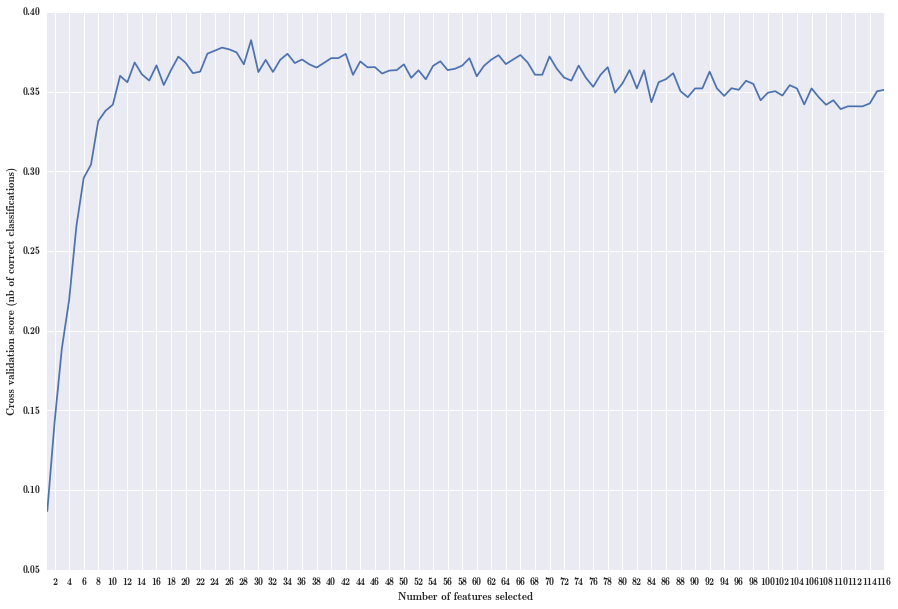

In [127]:
print("Optimal number of features : %d" %selector.n_features_)
print selector.support_ 
print selector.ranking_


#print  selector.grid_scores_

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 118, 2.0))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [128]:
#let's build a new dataframe from selected features
df4 = X1.iloc[:,selector.support_]
df4.head()

1     2    3     4     7     8     18    23    31    32   ...    62   \
0  7.84  2.91 0.98 -1.50 -1.21  1.85 -0.68 -0.68  0.82  0.90  ...   2.05   
1 -0.09 -0.60 0.50  0.87 -0.89  0.43  1.30  1.30 -0.36 -0.58  ...  -0.22   
2 -0.52 -0.79 1.21 -0.91 -0.69 -0.90 -0.36 -0.36 -0.75  0.07  ...  -0.35   
3 -0.68  2.06 0.72 -0.01  0.11  0.69  0.52  0.52  2.26  0.33  ...   0.19   
4  0.27 -0.28 0.08  1.05 -0.40 -0.87  1.27  1.27 -0.72 -0.73  ...  -0.19   

    66    87   88    89    90    91    93    95    102  
0  0.47  1.32 1.09 -0.94 -0.90 -0.73  0.39 -0.04 -0.91  
1 -0.63  1.63 1.99 -0.36 -0.18  0.41 -0.65 -0.95 -0.12  
2  0.80 -0.65 0.26 -0.42 -0.41  0.17 -1.20 -0.56  1.38  
3 -0.43  2.30 2.55  1.49 -0.18  0.11  0.79  0.17 -0.01  
4 -0.48  0.98 0.28 -0.78 -0.08 -0.25 -0.05 -0.50  0.27  

[5 rows x 29 columns]

In [129]:
#fix columns indexes

new_labels= range(0,df4.columns.size)
df4.columns = new_labels

Let's retry classification only with those 29 selected features

In [130]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


X1 = df4
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=30,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.229781661607
RandomForestClassifier: [ 0.37087912  0.40226629  0.36549708]
ExtraTreesClassifier:   [ 0.35714286  0.40509915  0.37134503]


Looks like scores are a bit higher than before. Let's try PCA and see if we can get better.

###PCA

We are going to build a new dataset using PCA on the selected features.  
Note that dataset has alreay been normalized

In [131]:
from sklearn.decomposition import PCA

pca = PCA()
Xs = df4
pca.fit(Xs)



PCA(copy=True, n_components=None, whiten=False)

In [132]:
Xs.head()


0     1    2     3     4     5     6     7     8     9   ...     19  \
0  7.84  2.91 0.98 -1.50 -1.21  1.85 -0.68 -0.68  0.82  0.90  ...   2.05   
1 -0.09 -0.60 0.50  0.87 -0.89  0.43  1.30  1.30 -0.36 -0.58  ...  -0.22   
2 -0.52 -0.79 1.21 -0.91 -0.69 -0.90 -0.36 -0.36 -0.75  0.07  ...  -0.35   
3 -0.68  2.06 0.72 -0.01  0.11  0.69  0.52  0.52  2.26  0.33  ...   0.19   
4  0.27 -0.28 0.08  1.05 -0.40 -0.87  1.27  1.27 -0.72 -0.73  ...  -0.19   

     20    21   22    23    24    25    26    27    28  
0  0.47  1.32 1.09 -0.94 -0.90 -0.73  0.39 -0.04 -0.91  
1 -0.63  1.63 1.99 -0.36 -0.18  0.41 -0.65 -0.95 -0.12  
2  0.80 -0.65 0.26 -0.42 -0.41  0.17 -1.20 -0.56  1.38  
3 -0.43  2.30 2.55  1.49 -0.18  0.11  0.79  0.17 -0.01  
4 -0.48  0.98 0.28 -0.78 -0.08 -0.25 -0.05 -0.50  0.27  

[5 rows x 29 columns]

####Plot of variances associated with PCs

[u'pc0', u'pc1', u'pc2', u'pc3', u'pc4', u'pc5', u'pc6', u'pc7', u'pc8', u'pc9', u'pc10', u'pc11', u'pc12', u'pc13', u'pc14', u'pc15', u'pc16', u'pc17', u'pc18', u'pc19', u'pc20', u'pc21', u'pc22', u'pc23', u'pc24', u'pc25', u'pc26', u'pc27', u'pc28']


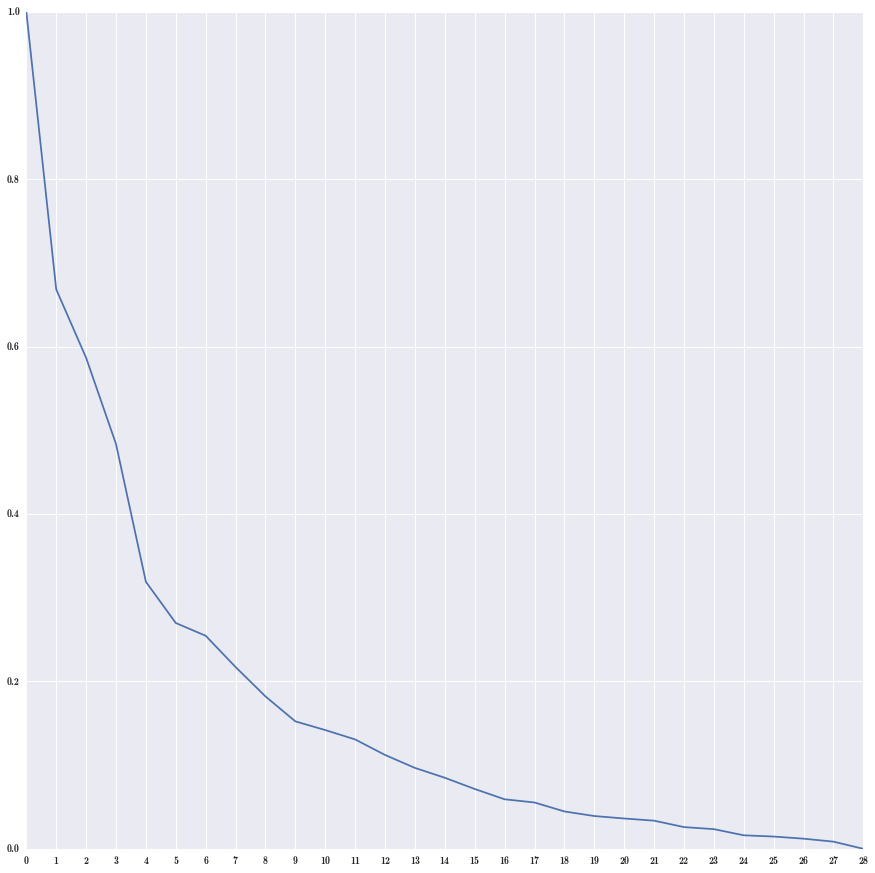

In [133]:
labels=['pc' + str(pc) for pc in range (0,29)]
var = pca.explained_variance_ratio_ / max(pca.explained_variance_ratio_)
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0, 70, 1))
plt.plot(var)

print labels

This plot returns a plot of the variances associated with the PCs. We can see that the first 8 PCs (from pc0 to pc7) are enough to explain most of the variance in the data set

In [134]:
df_pca = pd.DataFrame(pca.transform(Xs),columns=labels)
table(df_pca.head())

Let's try to plot each of these PCs with against each other:

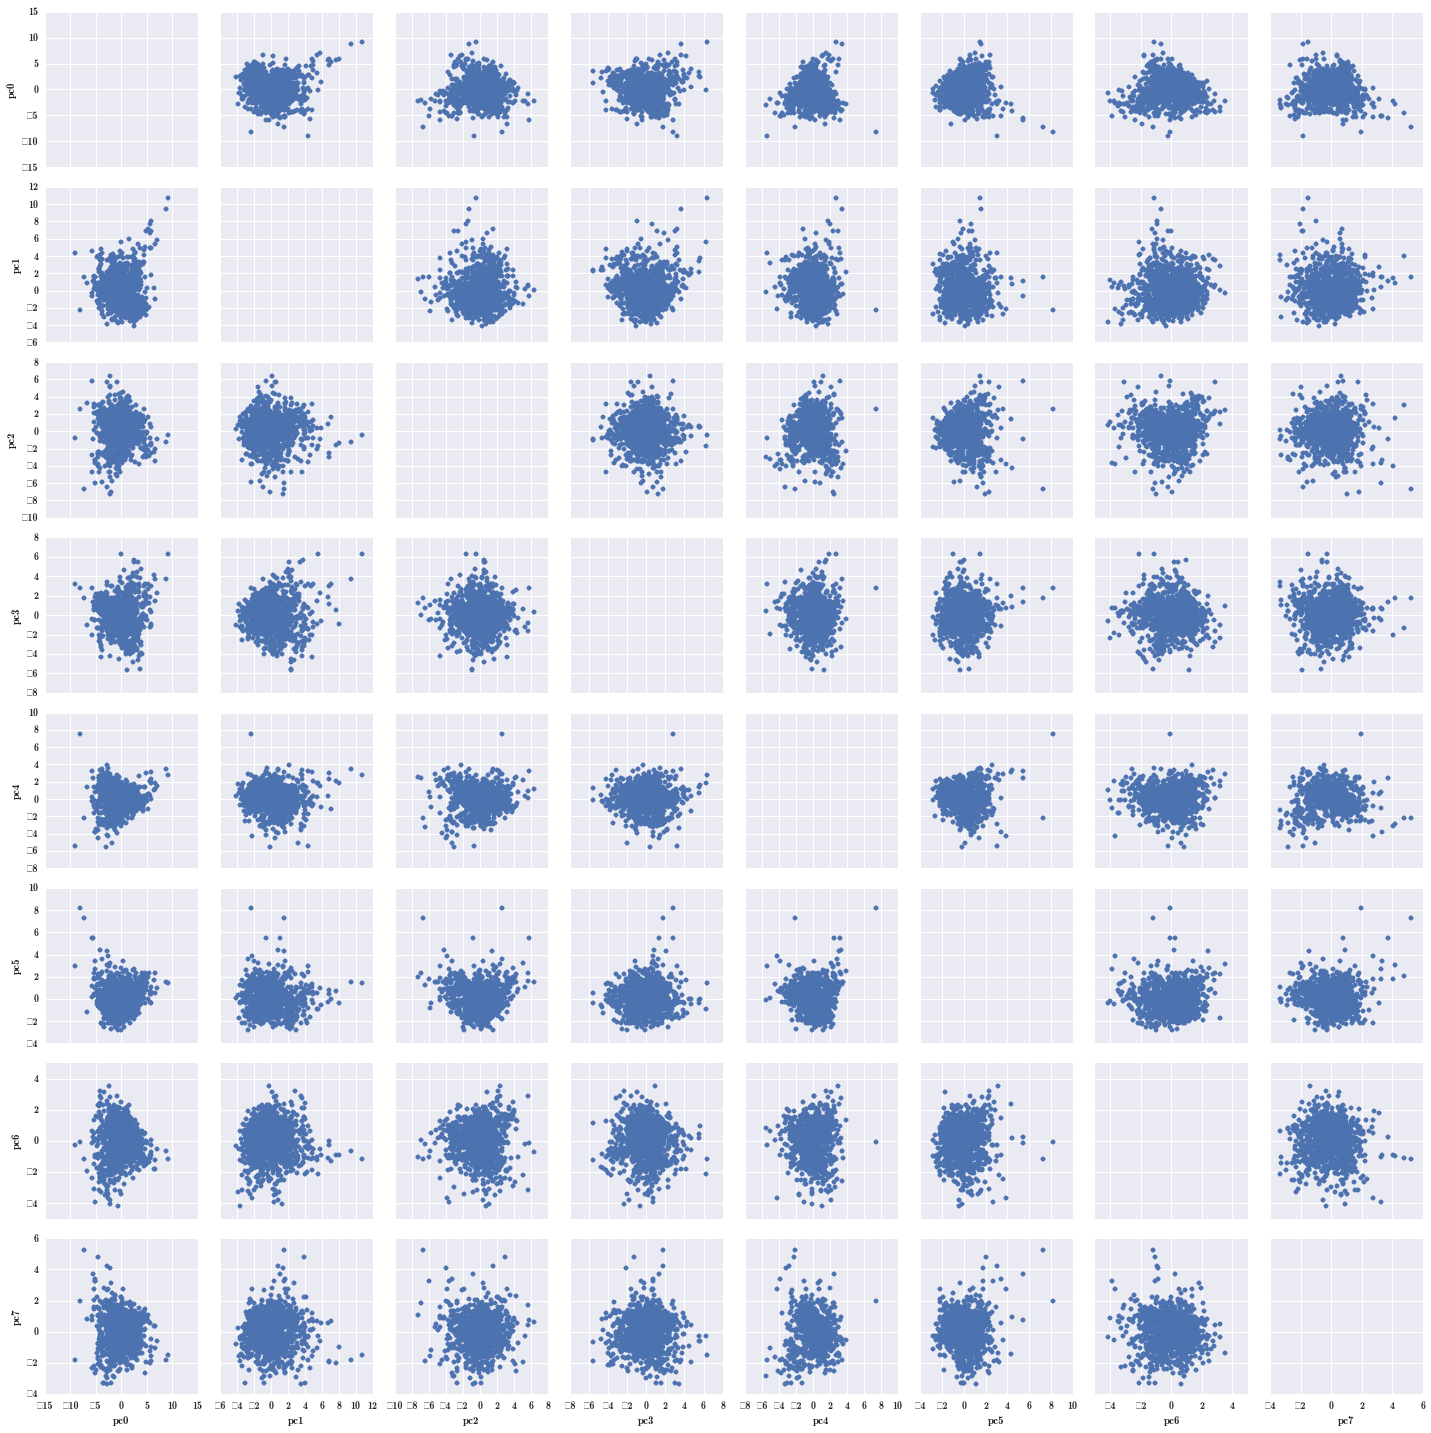

In [135]:
g = sns.PairGrid(df_pca.iloc[:,:8],size=2.5)
g.map_offdiag(plt.scatter)

In [136]:
print "If we had to explain what those 8 PCs represents compared to our 34 selected features, that would be how:"

for component in pca.components_[:8]:
    print " + ".join("%.3f x %s" % (value,"feature_"+str(name))
                    for value,name in zip(component,Xs.columns))
    print "\n"

If we had to explain what those 8 PCs represents compared to our 34 selected features, that would be how:
-0.066 x feature_0 + -0.238 x feature_1 + -0.154 x feature_2 + 0.180 x feature_3 + -0.073 x feature_4 + -0.210 x feature_5 + 0.238 x feature_6 + 0.238 x feature_7 + -0.258 x feature_8 + -0.193 x feature_9 + -0.290 x feature_10 + -0.231 x feature_11 + -0.093 x feature_12 + -0.073 x feature_13 + 0.176 x feature_14 + -0.175 x feature_15 + -0.252 x feature_16 + -0.296 x feature_17 + -0.093 x feature_18 + -0.248 x feature_19 + 0.068 x feature_20 + -0.161 x feature_21 + -0.224 x feature_22 + -0.219 x feature_23 + -0.059 x feature_24 + -0.197 x feature_25 + -0.096 x feature_26 + 0.024 x feature_27 + 0.038 x feature_28


0.091 x feature_0 + 0.013 x feature_1 + 0.118 x feature_2 + 0.095 x feature_3 + -0.088 x feature_4 + -0.178 x feature_5 + 0.313 x feature_6 + 0.313 x feature_7 + 0.004 x feature_8 + 0.109 x feature_9 + 0.162 x feature_10 + 0.157 x feature_11 + 0.311 x feature_12 + 0.358 x 

###Circles of correlation

     pc0   pc1   pc2   pc3   pc4   pc5   pc6   pc7
0   0.16 -0.18  0.62 -0.09  0.24 -0.28  0.03 -0.47
1   0.58 -0.03  0.04 -0.12 -0.07 -0.16  0.62 -0.31
2   0.37 -0.23 -0.70 -0.19 -0.06 -0.28 -0.14  0.07
3  -0.42 -0.18  0.05 -0.53  0.01  0.11  0.03 -0.27
4   0.17  0.17 -0.39  0.00 -0.02 -0.02  0.07  0.18
5   0.49  0.34 -0.30 -0.20  0.11 -0.05  0.01 -0.07
6  -0.55 -0.59  0.03 -0.52 -0.11  0.00  0.11  0.07
7  -0.55 -0.59  0.03 -0.52 -0.11  0.00  0.11  0.07
8   0.62 -0.01 -0.33 -0.17 -0.07  0.04  0.58 -0.10
9   0.46 -0.21 -0.51 -0.23 -0.29 -0.34 -0.26  0.03
10  0.70 -0.32 -0.22 -0.07 -0.11  0.14 -0.28 -0.16
11  0.56 -0.31 -0.50  0.00  0.12 -0.05 -0.24 -0.10
12  0.22 -0.60 -0.36  0.25  0.22  0.25  0.01 -0.29
13  0.17 -0.68 -0.29  0.36  0.14  0.21 -0.02 -0.20
14 -0.41 -0.66 -0.06 -0.54 -0.07  0.06  0.07  0.05
15  0.45 -0.18  0.42 -0.08  0.61 -0.20  0.13  0.13
16  0.62 -0.12  0.52 -0.33  0.07 -0.03 -0.18  0.09
17  0.70 -0.03  0.27 -0.09 -0.35  0.16  0.29  0.14
18  0.22 -0.12  0.13  0.03 -0.3

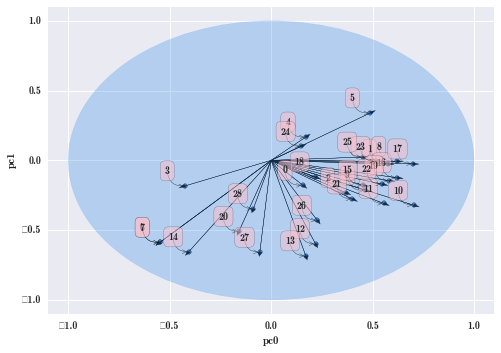

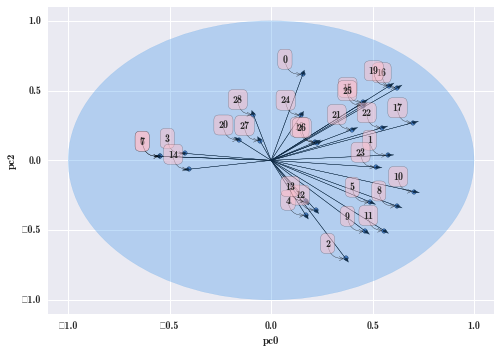

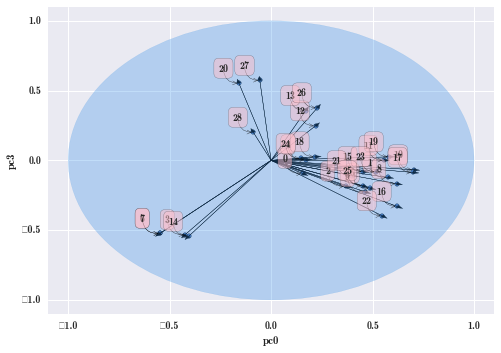

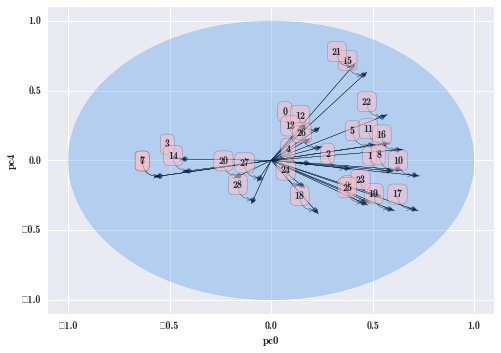

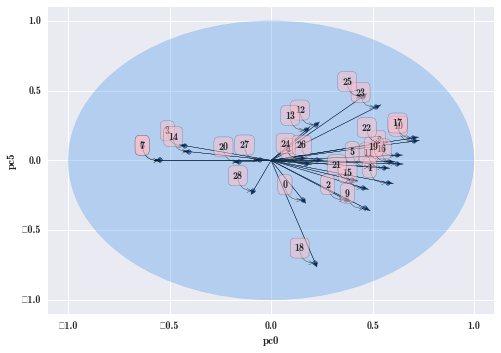

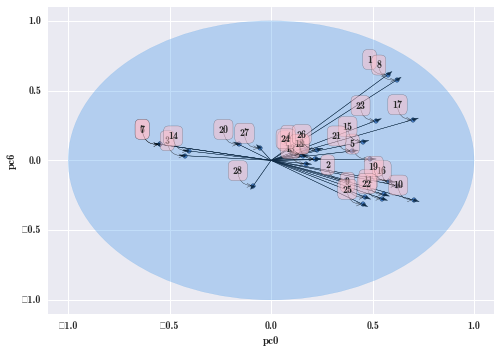

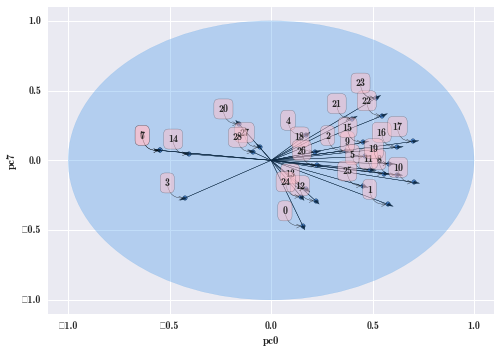

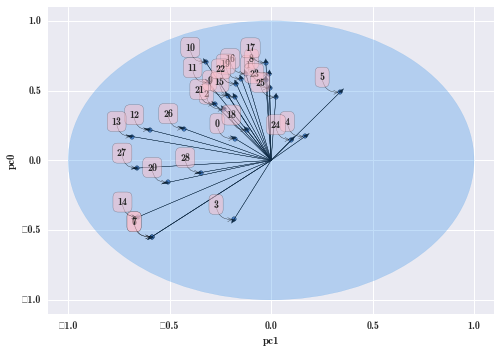

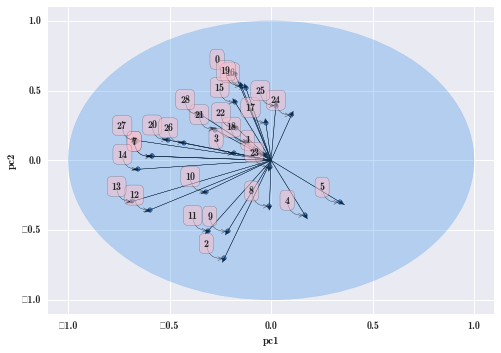

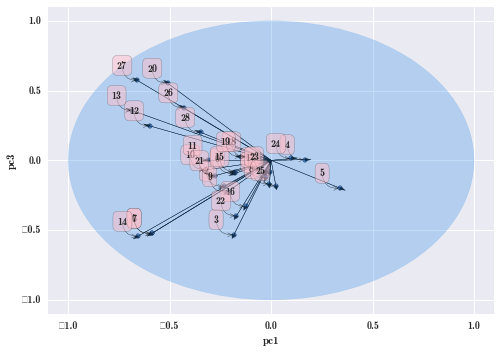

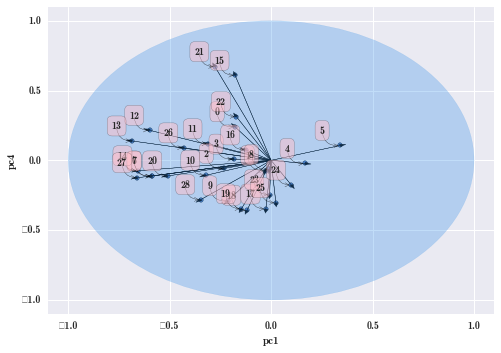

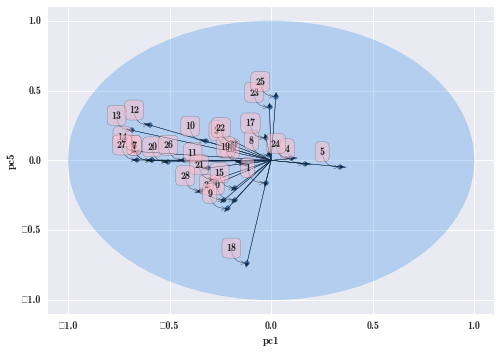

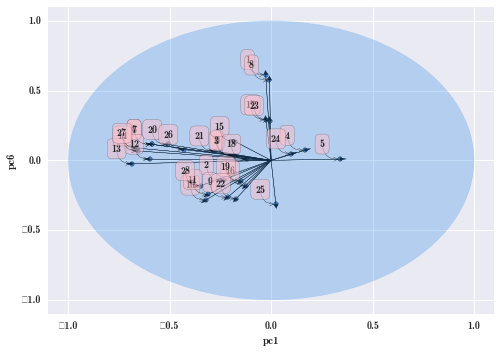

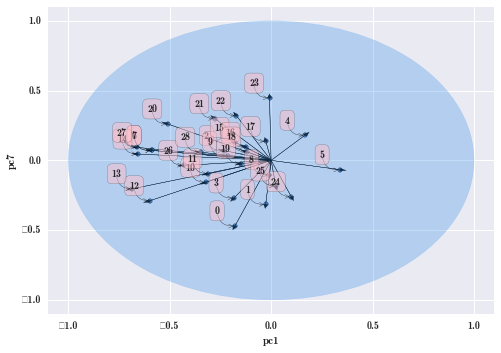

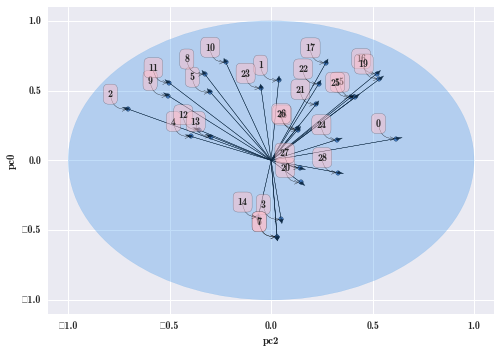

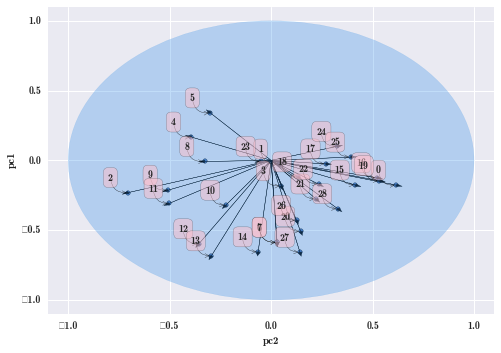

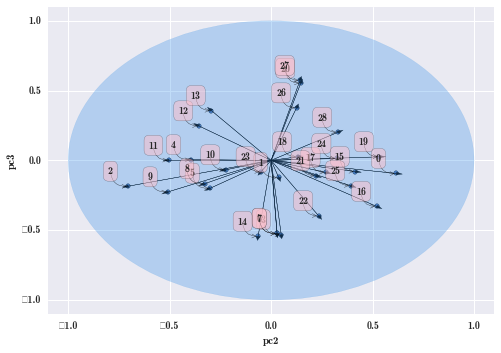

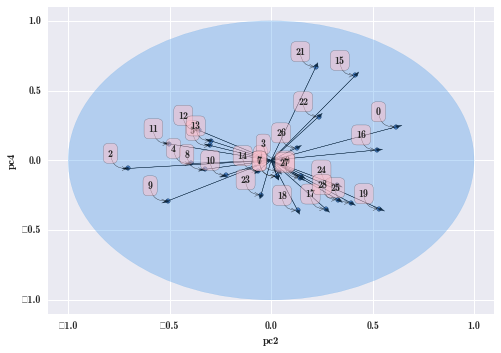

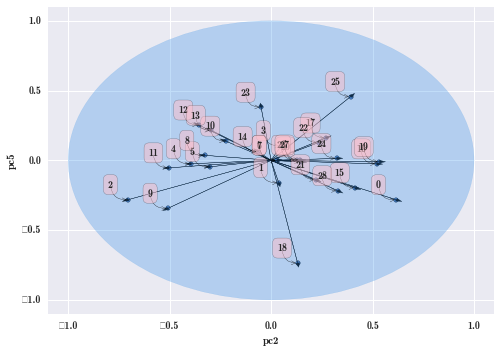

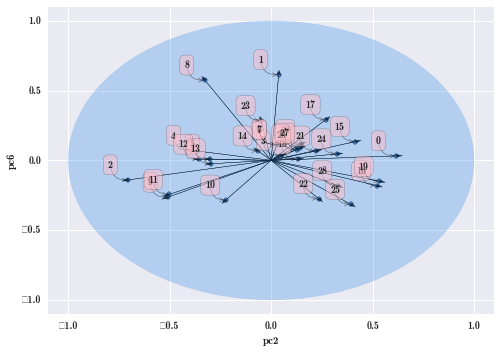

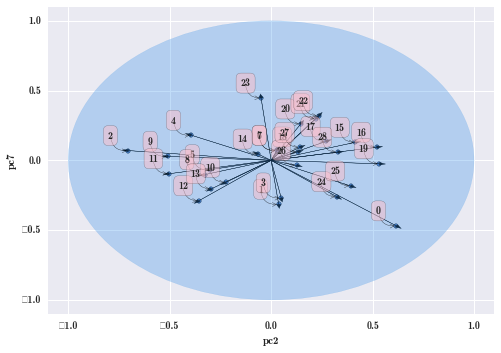

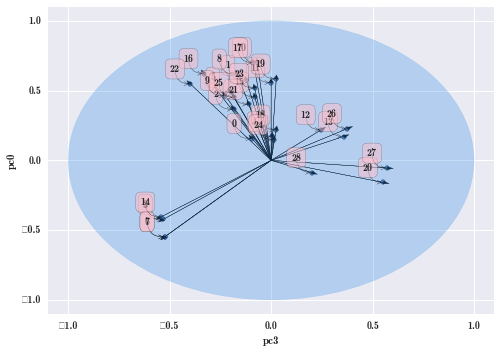

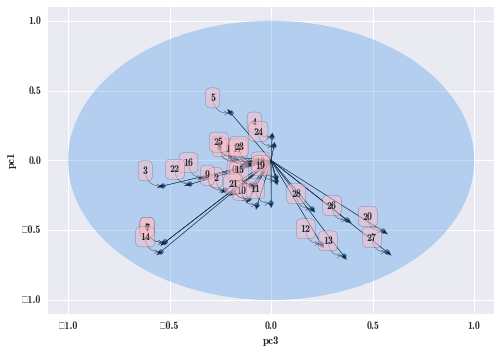

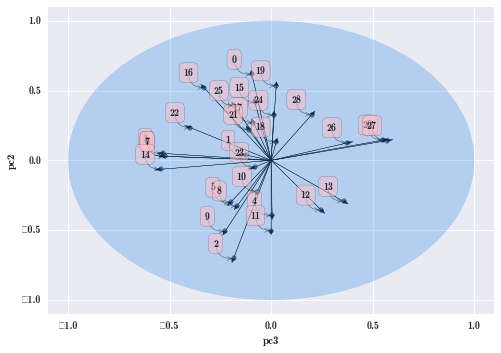

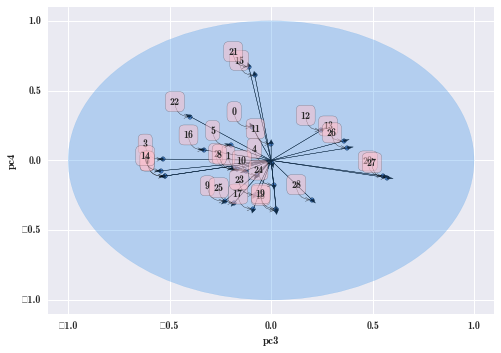

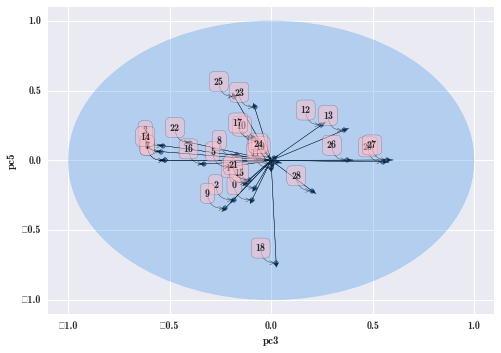

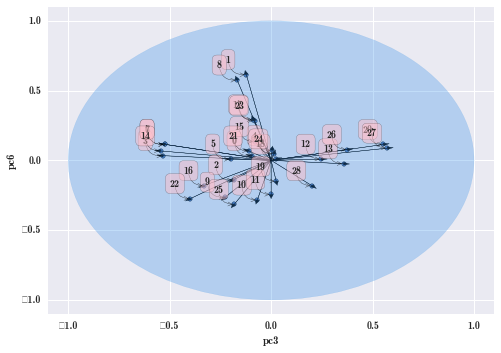

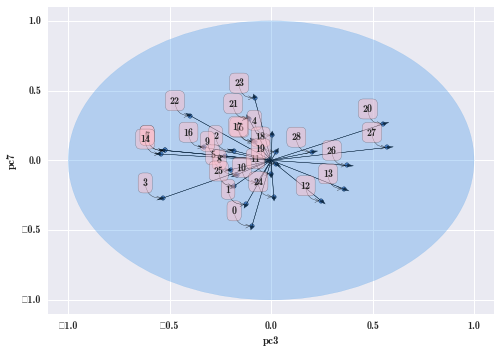

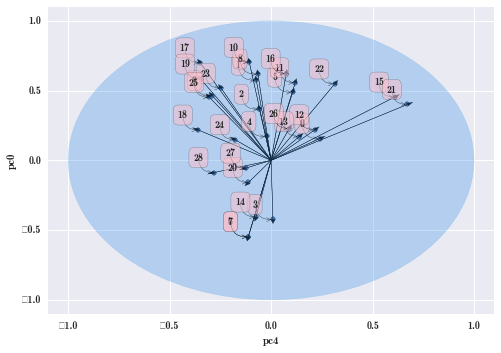

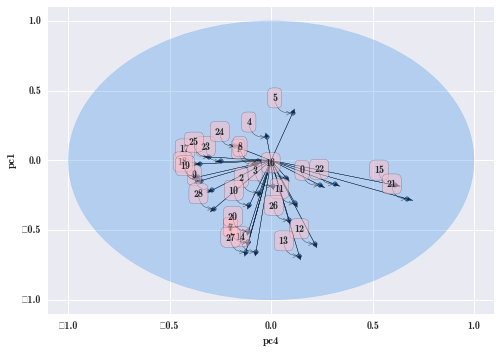

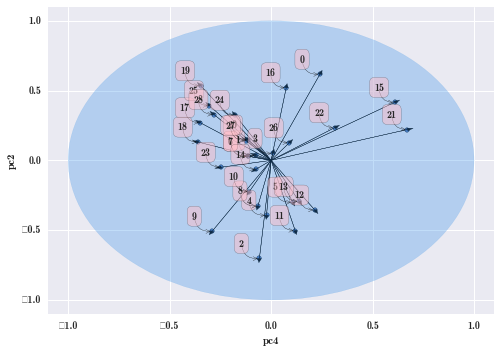

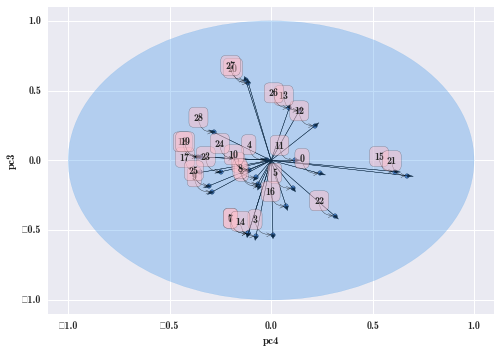

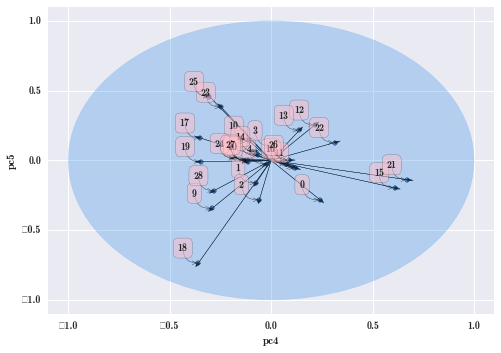

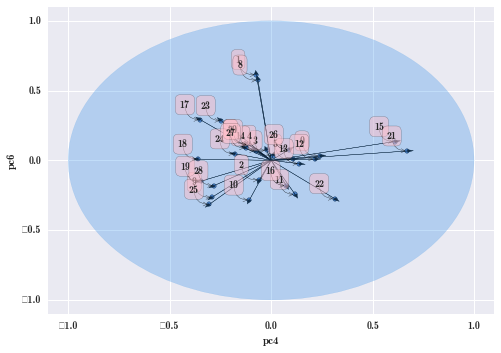

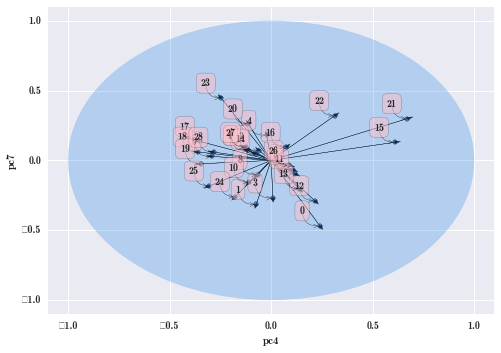

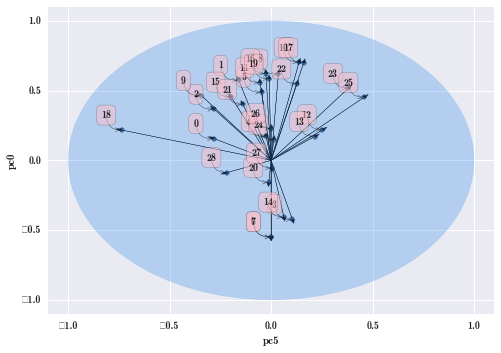

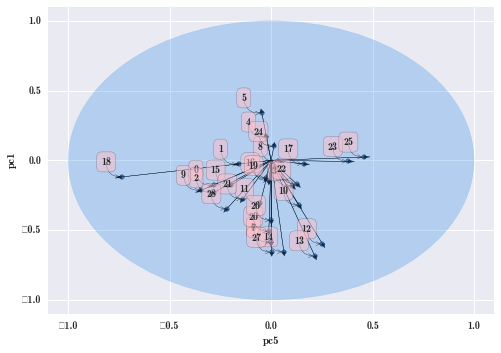

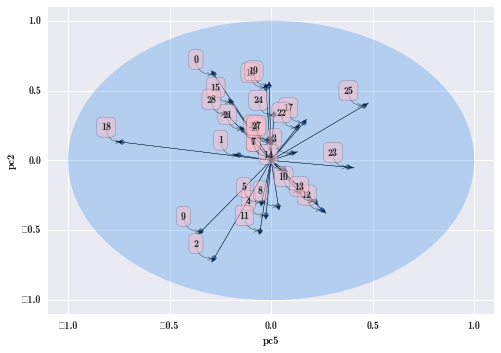

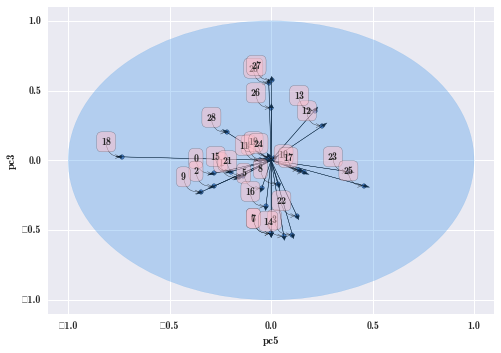

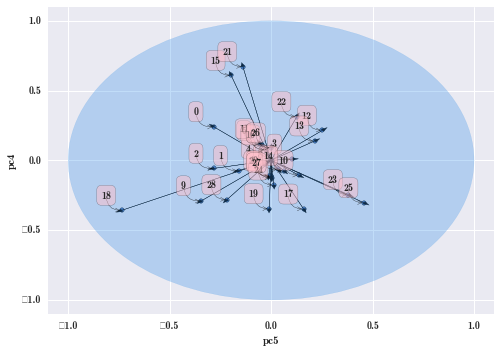

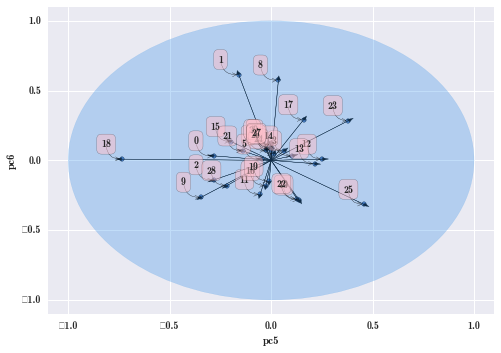

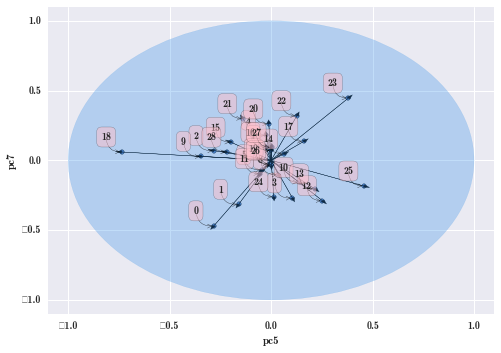

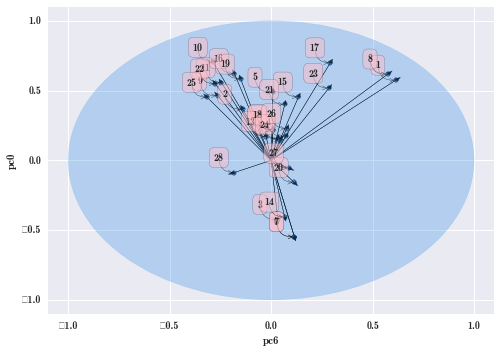

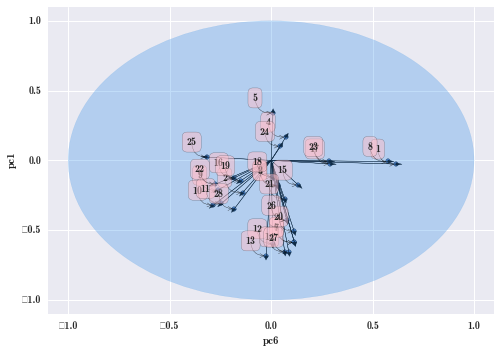

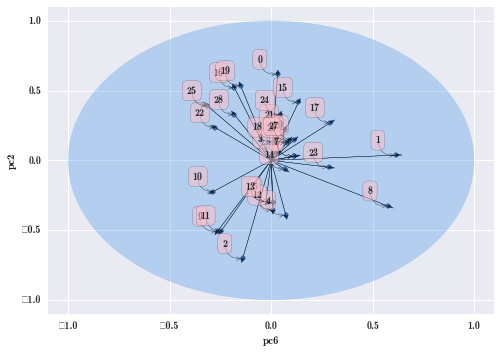

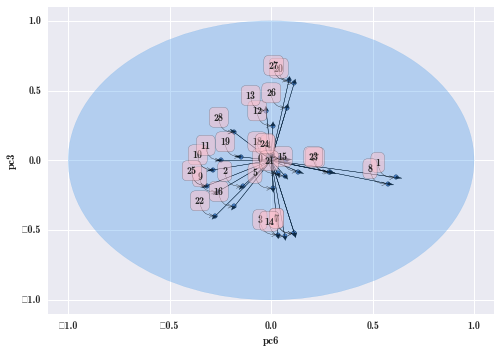

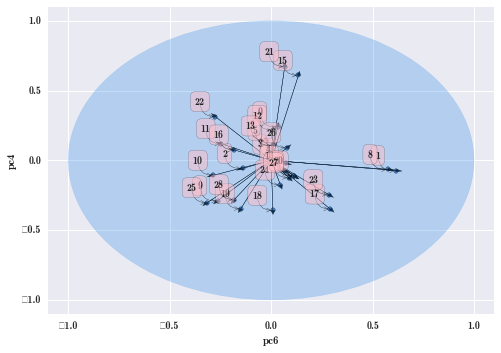

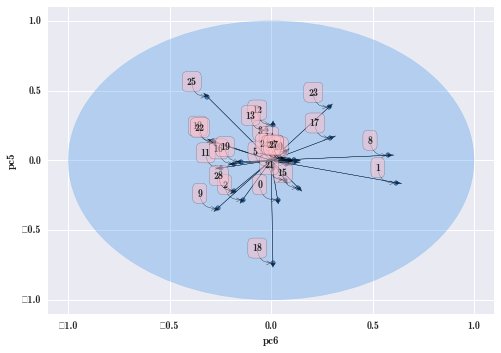

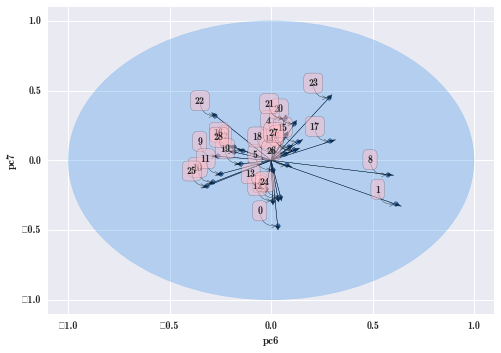

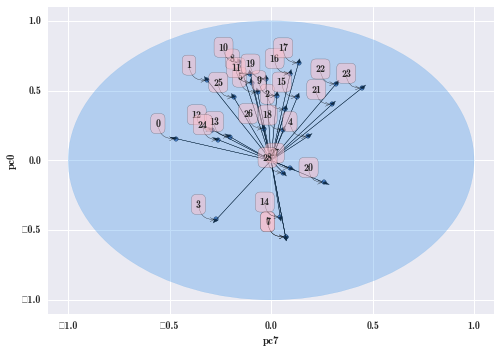

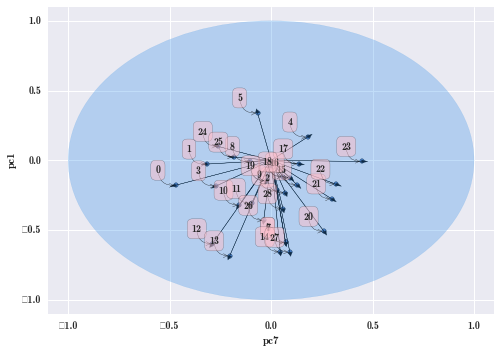

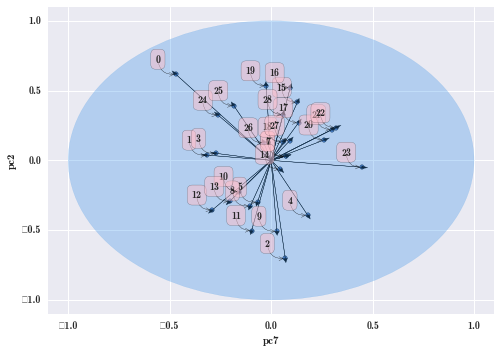

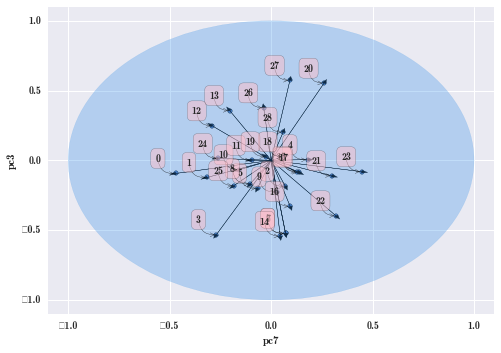

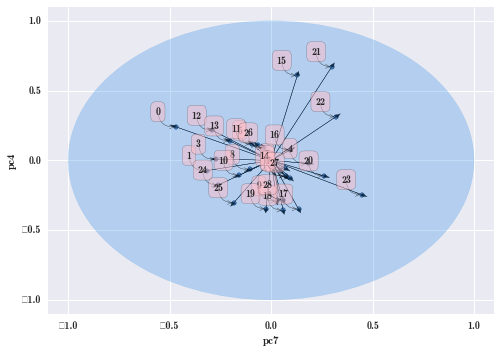

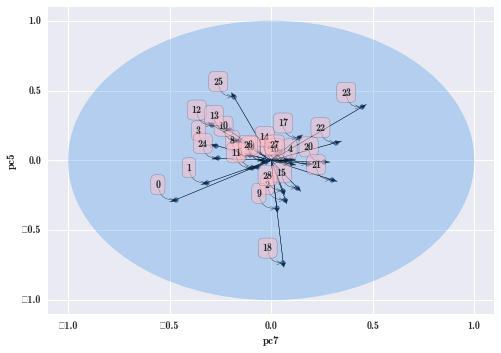

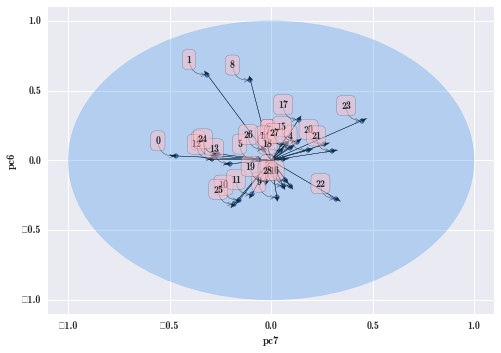

In [137]:
pcs = ['pc0','pc1','pc2','pc3','pc4','pc5','pc6','pc7']

corrs = [[np.corrcoef(df_pca[pc], Xs[feat])[0][1] * -1 for feat in Xs.columns] for pc in pcs]    
dfs = pd.DataFrame(corrs, columns=Xs.columns)
dfs.index = pcs
print dfs.T
for pcA in pcs:
    for pcB in pcs:
        if pcA != pcB:
            dfs.T.plot(kind='scatter',x=pcA,y=pcB)
            for label, x, y in zip(Xs.columns, dfs.T[pcA], dfs.T[pcB]):
                plt.annotate(
                    label, 
                    xy = (x, y), xytext = (-20, 10),
                    textcoords = 'offset points', ha = 'left', va = 'bottom',
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'pink', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.5'))
                plt.arrow( 0, 0, x, y, fc="k", ec="k")

            circle1=plt.Circle((0,0),1,color='#3490e9', alpha=0.3)
            fig = plt.gcf()
            fig.gca().add_artist(circle1)
            x1,x2,y1,y2 = plt.axis()
            plt.axis((-1.1,1.1,-1.1,1.1));

###Classification using first 8 PCs

In [139]:

# use our 1st 8 PCs as Xs
X1 = df_pca.iloc[:,:8]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=250,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=250,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.197068465333
RandomForestClassifier: [ 0.30494505  0.35127479  0.30116959]
ExtraTreesClassifier:   [ 0.28296703  0.35694051  0.30116959]


##LDA

In [140]:
from sklearn.lda import LDA

#let's re-use our 8 first PCs from the PCA output dataset

lda = LDA(solver='eigen')
#take first 8 PCAs
Xs = df_pca.iloc[:,:8]

#output labels: unique location mapped to int from 0 to 32
lda.fit(Xs, result['num_addr'])

LDA(n_components=None, priors=None, shrinkage=None, solver=u'eigen',
  store_covariance=False, tol=0.0001)

In [141]:


print lda.score(Xs, result['num_addr'])


0.336166194523


In [142]:
df_lda = pd.DataFrame(lda.transform(Xs))
df_lda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Data columns (total 8 columns):
0    1059 non-null float64
1    1059 non-null float64
2    1059 non-null float64
3    1059 non-null float64
4    1059 non-null float64
5    1059 non-null float64
6    1059 non-null float64
7    1059 non-null float64
dtypes: float64(8)
memory usage: 74.5 KB


##Classification: Random Forests

Let's use the LDA dataset to perform random forest classification 

In [143]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# use resulting dataset from LDA as Xs
X1 = df_lda
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


## DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf, X1, y1)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=250,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=250,  random_state=0)
scores = cross_val_score(clf, X1, y1)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.212754046808
RandomForestClassifier: [ 0.30494505  0.32294618  0.30116959]
ExtraTreesClassifier:   [ 0.3021978   0.33427762  0.28947368]


##Sklearn Multiclass Algorithms

The very low scores we are getting in our various classification attempts may be related to the fact that we have a high number of classes (33, i.e. one per location). Sklearn has multiclass algorithms that apply to our case:

"The sklearn.multiclass module implements meta-estimators to solve multiclass and multilabel classification problems by decomposing such problems into binary classification problems."

###OneVSRestClassifier

" The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy and is a fair default choice."

In [144]:

from sklearn.multiclass import OneVsRestClassifier



# Since LDA did bring any added-value, let's re-use our 8 PCs
X1 = df_pca.iloc[:,:8]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


clf = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=250,  random_state=0))
clf.fit(X1, y1)
Y_pred = clf.predict(X1)

print cross_val_score(clf, X1, y1)


[ 0.28846154  0.33144476  0.30409357]


###OneVsOneClassifier

"OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected."

In [145]:

from sklearn.multiclass import OneVsOneClassifier



# Since LDA did not bring any added-value, let's re-use our 8 PCs
X1 = df_pca.iloc[:,:8]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']


clf = OneVsOneClassifier(ExtraTreesClassifier(n_estimators=250,  random_state=0))
clf.fit(X1.values, y1.values)
Y_pred = clf.predict(X1.values)

print cross_val_score(clf, X1.values, y1.values)


[ 0.28571429  0.33427762  0.3128655 ]


###Error-correcting output-codes

"Output-code based strategies are fairly different from one-vs-the-rest and one-vs-one. With these strategies, each class is represented in a euclidean space, where each dimension can only be 0 or 1. Another way to put it is that each class is represented by a binary code (an array of 0 and 1). The matrix which keeps track of the location/code of each class is called the code book."

"At fitting time, one binary classifier per bit in the code book is fitted. At prediction time, the classifiers are used to project new points in the class space and the class closest to the points is chosen."

In [146]:
from sklearn.multiclass import OutputCodeClassifier

# Since LDA did bring any added-value, let's re-use our 8 PCs
X1 = df_pca.iloc[:,:8]
#use numbers (corresponding to specific locations) as Y
y1 = result['num_addr']

codesize=log2(33) /33

print codesize

clf = OutputCodeClassifier(ExtraTreesClassifier(n_estimators=250,random_state=0),code_size=codesize, random_state=0)
clf.fit(X1, y1)
Y_pred = clf.predict(X1)

print clf.score(X1,y1)


0.152860427859
0.704438149197


According to Sklearn documentation: when using a code_size > 1, although in theory some classifiers will correct for the mistakes made by other classifiers, in practice, this may not happen as classifier mistakes will typically be correlated.

In our case using codesize = log2(n_classes) / n_classes gives us a score of 0.7044 . Score increases as code_size increases until it reaches 1.0 (if code_size > 0.4)




##Conclusion

The best classification score we got were by performing classification directly on selected features of the 2nd dataset (0.405) and by using error-correcting output-code classifier (on 8 first PCs). However I am a bit suspicious about this score as it reaches 1.0 when the codesize increases.


No information is given by the authors about the set of music/songs used and about the way audio features have been extracted. Building an Out of sample dataset to test our model could be challenging: it implies "guessing" which MARSYAS options have been used to extract chromatic features (we get 56 instead of 48 chromatic features - see Annex B).


Music Information Retrieval can give us information about the song/music and I do believe that there are interesting things that can be done with this data. Even though authors mention that "ambiguous" tracks - tracks with influences from several countries- have been removed, choosing the capital of the country as an "origin" can be quite misleading since some regions of a same country have strong differences in music style.

From there, we can wonder if our initial goal was the right one: using music from only 2-3 places to start or perhaps focusing on classifying music by genre instead of geographical area, would have been more realistic goals.


##Annex A

Here is the exact list of the initial 68 audio features extracted, as specified in MARSYAS output file:

0 Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0   
1 Mean_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0     
2	 Mean_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     3	 Mean_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     4	 Mean_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     5	 Mean_Acc5_Mean_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     6	 Mean_Acc5_Mean_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     7	 Mean_Acc5_Mean_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     8	 Mean_Acc5_Mean_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     9	 Mean_Acc5_Mean_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    10	 Mean_Acc5_Mean_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    11	 Mean_Acc5_Mean_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    12	 Mean_Acc5_Mean_Mem20_MFCC8_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    13	 Mean_Acc5_Mean_Mem20_MFCC9_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    14	 Mean_Acc5_Mean_Mem20_MFCC10_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    15	 Mean_Acc5_Mean_Mem20_MFCC11_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    16	 Mean_Acc5_Mean_Mem20_MFCC12_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    17	 Mean_Acc5_Std_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0   
    18	 Mean_Acc5_Std_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    19	 Mean_Acc5_Std_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    20	 Mean_Acc5_Std_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    21	 Mean_Acc5_Std_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    22	 Mean_Acc5_Std_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    23	 Mean_Acc5_Std_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    24	 Mean_Acc5_Std_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    25	 Mean_Acc5_Std_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    26	 Mean_Acc5_Std_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    27	 Mean_Acc5_Std_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    28	 Mean_Acc5_Std_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    29	 Mean_Acc5_Std_Mem20_MFCC8_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    30	 Mean_Acc5_Std_Mem20_MFCC9_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    31	 Mean_Acc5_Std_Mem20_MFCC10_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    32	 Mean_Acc5_Std_Mem20_MFCC11_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    33	 Mean_Acc5_Std_Mem20_MFCC12_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    34	 Std_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0   
    35	 Std_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    36	 Std_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    37	 Std_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    38	 Std_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    39	 Std_Acc5_Mean_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    40	 Std_Acc5_Mean_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    41	 Std_Acc5_Mean_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    42	 Std_Acc5_Mean_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    43	 Std_Acc5_Mean_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    44	 Std_Acc5_Mean_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    45	 Std_Acc5_Mean_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    46	 Std_Acc5_Mean_Mem20_MFCC8_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    47	 Std_Acc5_Mean_Mem20_MFCC9_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    48	 Std_Acc5_Mean_Mem20_MFCC10_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    49	 Std_Acc5_Mean_Mem20_MFCC11_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    50	 Std_Acc5_Mean_Mem20_MFCC12_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    51	 Std_Acc5_Std_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0   
    52	 Std_Acc5_Std_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    53	 Std_Acc5_Std_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    54	 Std_Acc5_Std_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    55	 Std_Acc5_Std_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    56	 Std_Acc5_Std_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    57	 Std_Acc5_Std_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    58	 Std_Acc5_Std_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    59	 Std_Acc5_Std_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    60	 Std_Acc5_Std_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    61	 Std_Acc5_Std_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    62	 Std_Acc5_Std_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    63	 Std_Acc5_Std_Mem20_MFCC8_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    64	 Std_Acc5_Std_Mem20_MFCC9_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    65	 Std_Acc5_Std_Mem20_MFCC10_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    66	 Std_Acc5_Std_Mem20_MFCC11_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    67	 Std_Acc5_Std_Mem20_MFCC12_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0

##Annex B

Using MARSYAS to extract only chromatic features, we end up with the following dataset. We **assume** that the 48 chromatic features added to the initial dataset are the following (once removed "Mean_Acc5_Mean_Mem20_PeakRatio_Average" and "Mean_Acc5_Mean_Mem20_PeakRatio_Minimum" features):  

     1	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     2	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_A#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     3	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_B_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     4	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_C_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     5	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_C#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     6	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     7	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     8	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
     9	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    10	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    11	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    12	 Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    13	 Mean_Acc5_Mean_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    14	 Mean_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    15	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    16	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_A#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    17	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_B_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    18	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_C_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    19	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_C#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    20	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    21	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    22	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    23	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    24	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    25	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    26	 Mean_Acc5_Std_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    27	 Mean_Acc5_Std_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    28	 Mean_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    29	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    30	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_A#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    31	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_B_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    32	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_C_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    33	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_C#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    34	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    35	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    36	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    37	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    38	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    39	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    40	 Std_Acc5_Mean_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    41	 Std_Acc5_Mean_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    42	 Std_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    43	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    44	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_A#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    45	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_B_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    46	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_C_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    47	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_C#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    48	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    49	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    50	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    51	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    52	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    53	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    54	 Std_Acc5_Std_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    55	 Std_Acc5_Std_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0   
    56	 Std_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0  

##Annex C - HowTo extract audio features using MARSYAS


MARSYAS works with uncompressed audio files, you have to convert mp3 to WAV files using avconv.

- To install avconv, run:  
`apt-get install libav-tools`  


- To convert an MP3 to WAV:  
`avconv -c mp3 -i my_song.mp3 my_song.wav`  


- Create a collection of the audio files you want to process through MARSYAS assuming /home/vagrant/wav is the folder containing your audio files:  
`mkcollection -c mycoll.mf /home/vagrant/wav`  



- Extract 68 timbral features  (Time Zero Crossings, Spectral Centroid, Spectral Flux, Spectral Rolloff qnd MFCC) using default MARSYAS settings:  
` bextract -sv -mfcc -zcrs -ctd -rlf -flx mycoll.mf -w output.arff `  


output.arff contains the comma-separated extracted features.

- To extract chromatic features:  
` bextract -sv -chroma mycoll.mf -w output.arff `

